# Wedge Project Material Stock Projection - Approach 2: Material Use Intensity
This Jupyter notebook uses two approaches for projecting material stocks until 2050 in the US building and infrastructure sectors.
1. **Approach 1** uses historic material consumption data and ARIMA/SARIMA time series moving average models to project material consumptions. Historic data is mostly obtained from USGS for raw building material ingredients (e.g., cement, steel, lime, etc.)
2. **Approach 2** uses floor area projections (for buildings, and possibly for infrastructure) and material intensity data to project material consumptions. Building-level data is primarily available per building material categories (e.g., concrete, steel, rebar, bricks, etc.)

Each approach uses a different set of input data and modeling principles with certain scopes according to the granularity and scope of available data.

Python scripts are developed to clean and organize input data, perform calculations, and export modeling results. Descriptions are also provided whenever necessary.

**Note:** the core analysis only uses A1 to A3 data.

## Import libraries

In [12]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

In [13]:
# Set the default font family for all plots
plt.rcParams['font.family'] = 'Calibri'  # Or any other font you prefer
# ['sans-serif'] was previously selected.

## Import Data

In [3]:
wblca_meta_data = pd.read_excel('./Input Data/buildings_metadata_02-21-2025.xlsx')

In [4]:
# Load the CSV file into a DataFrame
wblca_results_full = pd.read_excel('./Input Data/full_lca_results_02-21-2025.xlsx')

In [7]:
# Remove rows where inv_mass or gwp is 0 or NaN
wblca_results_full = wblca_results_full[
    (~wblca_results_full['inv_mass'].isin([0, np.nan])) &
    (~wblca_results_full['gwp'].isin([0, np.nan]))
].reset_index(drop=True)

In [8]:
wblca_results_full.head()

project_index omniclass_element mat_group                 mat_type  \
0              1      Substructure     Steel              Steel sheet   
1              1      Substructure  Coatings         Coatings - other   
2              1      Substructure  Concrete        Ready mix NW 4000   
3              1      Substructure     Steel  Rebar and reinforcement   
4              1      Substructure  Concrete        Ready mix NW 4000   

  mat_csi_division tally_revit_building_element tally_material_group  \
0      05 - Metals                 Substructure                Metal   
1      05 - Metals                 Substructure        Metal Coating   
2    03 - Concrete               Superstructure             Concrete   
3    03 - Concrete               Superstructure                Metal   
4    03 - Concrete               Superstructure             Concrete   

  oneclick_omniclass oneclick_resource_type  service_life  ...       inv_mass  \
0                NaN                    NaN            45  ...   14953.126660   
1                NaN                    NaN            50  ...      29.247803   
2                NaN                    NaN            60  ...  853083.412800   
3                NaN                    NaN            60  ...   18030.252870   
4                NaN                    NaN            60  ...  254305.012100   

   inv_stored_carbon            gwp         ep          ap          sfp  \
0                0.0   34840.785118   6.145735  135.475328  1899.047086   
1                0.0     312.951490   0.040362    0.345124     6.346773   
2                0.0  136036.682423  28.415153  460.278336  9695.231536   
3                0.0   34437.782982   4.363321  144.963233  1718.283098   
4                0.0   40552.670056   8.470585  137.209429  2890.158144   

            odp          nred    mui_gfa    mui_cfa  
0  4.441080e-04  4.142016e+05   0.598125   0.308312  
1  1.278129e-10  5.235357e+03   0.001170   0.000603  
2  2.398774e-08  1.058441e+06  34.123337  17.589349  
3 -1.552400e-04  4.164988e+05   0.721210   0.371758  
4  7.150769e-09  3.155222e+05  10.172200   5.243402  

[5 rows x 21 columns]

In [9]:
wblca_results_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253356 entries, 0 to 253355
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   project_index                 253356 non-null  int64  
 1   omniclass_element             253356 non-null  object 
 2   mat_group                     253356 non-null  object 
 3   mat_type                      253356 non-null  object 
 4   mat_csi_division              253356 non-null  object 
 5   tally_revit_building_element  245313 non-null  object 
 6   tally_material_group          245767 non-null  object 
 7   oneclick_omniclass            7589 non-null    object 
 8   oneclick_resource_type        7589 non-null    object 
 9   service_life                  253356 non-null  int64  
 10  life_cycle_stage              253356 non-null  object 
 11  inv_mass                      253356 non-null  float64
 12  inv_stored_carbon             253356 non-nul

In [10]:
wblca_meta_data.head()

project_index   site_country        site_region site_state_province  \
0              1         Canada             Canada    British Columbia   
1              2  United States            Eastern                 NaN   
2              3  United States  Pacific Southwest                 NaN   
3              4  United States      South Eastern                 NaN   
4              5  United States  Pacific Southwest                 NaN   

             site_clim_zone  bldg_code_year  bldg_energy_code_year  \
0        Can. 4 (<3000 HDD)             NaN                    NaN   
1   Can. 7B (6000-6999 HDD)          2018.0                 2018.0   
2  Zone 1A (Very Hot Humid)          2012.0                 2015.0   
3  Zone 1A (Very Hot Humid)          2020.0                 2020.0   
4  Zone 1A (Very Hot Humid)          2012.0                 2015.0   

   bldg_compl_year    bldg_proj_type bldg_ibc_type  ... nredi_a_to_c_gfa  \
0              NaN  New Construction      Type I-B  ...     11444.145470   
1           2022.0  New Construction      Type I-A  ...      3471.081576   
2           2024.0  New Construction     Type II-B  ...      6539.973610   
3              NaN  New Construction      Type I-B  ...      4873.559066   
4           2024.0  New Construction     Type II-B  ...      6718.389264   

   mui_total_cfa  eci_a_to_c_cfa  epi_a_to_c_cfa  api_a_to_c_cfa  \
0    1625.942420      580.266958        0.124968        2.137669   
1    2173.943333      558.377867        0.454992        2.181800   
2    1892.665154      582.688842        0.131963        1.997141   
3    1260.237707      375.177682        0.067857        1.380832   
4    1395.069912      582.942427        0.116482        2.307666   

   sfpi_a_to_c_cfa odpi_a_to_c_cfa nredi_a_to_c_cfa  ec_per_occupant_a_to_c  \
0        34.967106    4.923251e-06      5899.044057            10528.599868   
1        35.413576    1.954153e-05      3392.982240                     NaN   
2        33.740725    3.382413e-06      6539.973610              965.577432   
3        21.952562   -7.195596e-08      3952.997909             4312.387153   
4        34.205557    3.236020e-06      6718.389264             2204.644740   

   ec_per_res_unit_a_to_c  
0            75450.261252  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  

[5 rows x 72 columns]

In [181]:
wblca_meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   project_index             292 non-null    object 
 1   site_country              292 non-null    object 
 2   site_region               292 non-null    object 
 3   site_state_province       221 non-null    object 
 4   site_clim_zone            292 non-null    object 
 5   bldg_code_year            270 non-null    float64
 6   bldg_energy_code_year     252 non-null    float64
 7   bldg_compl_year           214 non-null    float64
 8   bldg_proj_type            292 non-null    object 
 9   bldg_ibc_type             280 non-null    object 
 10  bldg_park_type            292 non-null    object 
 11  bldg_cfa                  243 non-null    float64
 12  bldg_gfa                  243 non-null    float64
 13  bldg_park_gfa             75 non-null     float64
 14  bldg_added

In [14]:
print(wblca_meta_data['bldg_prim_use'].unique())

['Residential: Multifamily (5 or more units)' 'Office' 'Education'
 'Healthcare' 'Warehouse and Storage' 'Industrial' 'Public Assembly'
 'Parking' 'Public Order and Safety' 'Lodging' 'Laboratory' 'Mercantile'
 'Transportation Hub' 'Other' 'Religious Worship' 'Food Service']


## Data Pre-Processing

### Add A1-A3 level MUI and ECI to `wblca_meta_data`

In [15]:
# Filter the dataframe for Life Cycle Stage "A1-A3"
wblca_results_full_a1_to_a3 = wblca_results_full[wblca_results_full['life_cycle_stage'] == 'A1-A3']
wblca_results_full_a1_to_a3['project_index'] = wblca_results_full_a1_to_a3['project_index'].astype(str)

# Aggregate inv_mass and gwp by project_index
aggregated_df = wblca_results_full_a1_to_a3.groupby('project_index').agg(
    total_mass_a1_to_a3=('inv_mass', 'sum'),  # Sum inv_mass
    total_gwp_a1_to_a3=('gwp', 'sum')        # Sum gwp
).reset_index()

aggregated_df['project_index'] = aggregated_df['project_index'].astype(str)
wblca_meta_data['project_index'] = wblca_meta_data['project_index'].astype(str)

# Step 2: Merge aggregated data with bldg_cfa from metadata
aggregated_df = aggregated_df.merge(
    wblca_meta_data[['project_index', 'bldg_cfa']], on='project_index', how='left'
)

# Step 3: Compute Material Use Intensity (mui) and Embodied Carbon Intensity (eci)
aggregated_df['total_mui_a1_to_a3'] = np.where(
    aggregated_df['bldg_cfa'] != 0, aggregated_df['total_mass_a1_to_a3'] / aggregated_df['bldg_cfa'], np.nan
)

aggregated_df['total_eci_a1_to_a3'] = np.where(
    aggregated_df['bldg_cfa'] != 0, aggregated_df['total_gwp_a1_to_a3'] / aggregated_df['bldg_cfa'], np.nan
)

# ✅ Drop 'bldg_cfa' after calculations
aggregated_df = aggregated_df.drop(columns=['bldg_cfa'])

# Merge the aggregated data with the wblca_meta_data dataframe
wblca_meta_data = pd.merge(wblca_meta_data, aggregated_df, on='project_index', how='left')

# Display the merged dataframe
wblca_meta_data.head()


C:\Users\ashtiani\AppData\Local\Temp\ipykernel_33808\3711530083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wblca_results_full_a1_to_a3['project_index'] = wblca_results_full_a1_to_a3['project_index'].astype(str)


project_index   site_country        site_region site_state_province  \
0             1         Canada             Canada    British Columbia   
1             2  United States            Eastern                 NaN   
2             3  United States  Pacific Southwest                 NaN   
3             4  United States      South Eastern                 NaN   
4             5  United States  Pacific Southwest                 NaN   

             site_clim_zone  bldg_code_year  bldg_energy_code_year  \
0        Can. 4 (<3000 HDD)             NaN                    NaN   
1   Can. 7B (6000-6999 HDD)          2018.0                 2018.0   
2  Zone 1A (Very Hot Humid)          2012.0                 2015.0   
3  Zone 1A (Very Hot Humid)          2020.0                 2020.0   
4  Zone 1A (Very Hot Humid)          2012.0                 2015.0   

   bldg_compl_year    bldg_proj_type bldg_ibc_type  ... api_a_to_c_cfa  \
0              NaN  New Construction      Type I-B  ...       2.137669   
1           2022.0  New Construction      Type I-A  ...       2.181800   
2           2024.0  New Construction     Type II-B  ...       1.997141   
3              NaN  New Construction      Type I-B  ...       1.380832   
4           2024.0  New Construction     Type II-B  ...       2.307666   

   sfpi_a_to_c_cfa  odpi_a_to_c_cfa  nredi_a_to_c_cfa  ec_per_occupant_a_to_c  \
0        34.967106     4.923251e-06       5899.044057            10528.599868   
1        35.413576     1.954153e-05       3392.982240                     NaN   
2        33.740725     3.382413e-06       6539.973610              965.577432   
3        21.952562    -7.195596e-08       3952.997909             4312.387153   
4        34.205557     3.236020e-06       6718.389264             2204.644740   

   ec_per_res_unit_a_to_c total_mass_a1_to_a3 total_gwp_a1_to_a3  \
0            75450.261252        7.653859e+07       2.254295e+07   
1                     NaN        4.328714e+08       1.017477e+08   
2                     NaN        4.755715e+06       1.226292e+06   
3                     NaN        2.218759e+07       5.416885e+06   
4                     NaN        5.182974e+06       1.855065e+06   

   total_mui_a1_to_a3  total_eci_a1_to_a3  
0         1578.115339          464.803054  
1         2164.356905          508.738385  
2         1829.121246          471.650627  
3         1232.643691          300.938069  
4         1346.226899          481.835151  

[5 rows x 76 columns]

### Exclude outlier projects
We use a z-score criteria here to detect outliers with this conditions:
* Due to high variability, use log-transformed data to detect outliers.
* If either the absolute z-score values for `total_mui_a1_to_a3` OR `total_eci_a1_to_a1` are greater than 3, the `project_index` is excluded.

In [16]:
# Creating a copy to avoid modifying the original dataframe
wblca_meta_data_log = wblca_meta_data.copy()

# Selecting relevant features
features = ['total_mui_a1_to_a3', 'total_eci_a1_to_a3']

# Ensure numeric data and replace zeros (log issues)
for col in features:
    wblca_meta_data_log[col] = pd.to_numeric(wblca_meta_data_log[col], errors='coerce')
    wblca_meta_data_log[col] = wblca_meta_data_log[col].replace(0, np.nan)  # Avoid log(0)

# Create separate log-transformed columns
for col in features:
    wblca_meta_data_log[f'log_{col}'] = np.log1p(wblca_meta_data_log[col])  # log1p to handle zeros

# Compute mean and standard deviation for z-score
mean_vals = wblca_meta_data_log[[f'log_{col}' for col in features]].mean()
std_vals = wblca_meta_data_log[[f'log_{col}' for col in features]].std()

# Compute z-score for log-transformed values
for col in features:
    wblca_meta_data_log[f'z_score_log_{col}'] = (wblca_meta_data_log[f'log_{col}'] - mean_vals[f'log_{col}']) / std_vals[f'log_{col}']

# Identify outliers where any absolute z-score is greater than 3
outlier_df = wblca_meta_data_log[
    (wblca_meta_data_log['z_score_log_total_mui_a1_to_a3'].abs() > 3) | 
    (wblca_meta_data_log['z_score_log_total_eci_a1_to_a3'].abs() > 3)
]

# Filter wblca_meta_data to exclude these project_index values
wblca_meta_data = wblca_meta_data[
    ~wblca_meta_data['project_index'].isin(outlier_df['project_index'])
]

outlier_df.head(5)


project_index   site_country        site_region site_state_province  \
25             26  United States  Pacific Southwest          California   
142           143  United States  Pacific Northwest              Oregon   
143           144         Canada             Canada    British Columbia   
159           160  United States  Pacific Northwest          Washington   

             site_clim_zone  bldg_code_year  bldg_energy_code_year  \
25        Zone 2B (Hot Dry)             NaN                    NaN   
142  Zone 4C (Mixed Marine)          2019.0                 2021.0   
143  Zone 4C (Mixed Marine)          2018.0                    NaN   
159  Zone 4C (Mixed Marine)          2012.0                 2012.0   

     bldg_compl_year    bldg_proj_type bldg_ibc_type  ...  \
25               NaN  New Construction     Type II-B  ...   
142           2024.0  New Construction      Type I-B  ...   
143           2025.0  New Construction           NaN  ...   
159           2022.0  New Construction      Type I-B  ...   

    ec_per_occupant_a_to_c  ec_per_res_unit_a_to_c  total_mass_a1_to_a3  \
25            18189.484872                     NaN         3.900746e+07   
142            1101.455803                     NaN         2.921177e+06   
143                    NaN                     NaN         5.725126e+06   
159                    NaN                     NaN         1.986205e+07   

     total_gwp_a1_to_a3  total_mui_a1_to_a3  total_eci_a1_to_a3  \
25         1.061793e+07         4906.598170         1335.589089   
142        1.886486e+06          129.830090           83.843805   
143        1.475869e+06          269.417712           69.452680   
159        1.398645e+07         2739.593494         1929.165151   

    log_total_mui_a1_to_a3 log_total_eci_a1_to_a3  \
25                8.498540               7.197876   
142               4.873899               4.440812   
143               5.599968               4.254941   
159               7.915930               7.565361   

     z_score_log_total_mui_a1_to_a3  z_score_log_total_eci_a1_to_a3  
25                         3.296901                        2.847190  
142                       -4.309799                       -3.169046  
143                       -2.786066                       -3.574637  
159                        2.074231                        3.649084  

[4 rows x 80 columns]

In [17]:
# Filter wblca_meta_data to exclude rows where project_index is in outlier_df
wblca_meta_data = wblca_meta_data[
    ~wblca_meta_data['project_index'].isin(outlier_df['project_index'])
]

In [18]:
# Filter your dataframe based on 'proj_type'
wblca_meta_data_new_construction = wblca_meta_data[wblca_meta_data['bldg_proj_type'] == 'New Construction']

# Get descriptive statistics for filtered data
wblca_meta_data_new_construction.describe()

bldg_code_year  bldg_energy_code_year  bldg_compl_year       bldg_cfa  \
count      218.000000             205.000000       179.000000     239.000000   
mean      2016.110092            2016.068293      2022.469274   19664.811715   
std          2.887569               3.215346         2.675924   25515.869635   
min       2006.000000            2004.000000      2010.000000     130.000000   
25%       2015.000000            2015.000000      2021.000000    3800.000000   
50%       2016.000000            2016.000000      2023.000000   11100.000000   
75%       2018.000000            2018.000000      2024.000000   24500.000000   
max       2023.000000            2023.000000      2030.000000  200000.000000   

            bldg_gfa  bldg_park_gfa  bldg_added_gfa  bldg_renovated_gfa  \
count     239.000000      68.000000             0.0                 0.0   
mean    16802.133891   10061.470588             NaN                 NaN   
std     22149.554732   11498.017385             NaN                 NaN   
min         0.000000     150.000000             NaN                 NaN   
25%      3575.000000    2912.500000             NaN                 NaN   
50%      9600.000000    6050.000000             NaN                 NaN   
75%     21600.000000   14700.000000             NaN                 NaN   
max    195500.000000   62000.000000             NaN                 NaN   

       bldg_occupants  bldg_res_units  ...  api_a_to_c_cfa  sfpi_a_to_c_cfa  \
count      188.000000       39.000000  ...      239.000000       239.000000   
mean      2294.710968      221.974359  ...        2.247409        29.051543   
std       6702.391674      169.165831  ...        1.242268        19.209744   
min          8.000000        3.000000  ...        0.560692         3.841691   
25%        503.000000      100.500000  ...        1.425417        20.296976   
50%       1049.500000      186.000000  ...        2.015914        26.095116   
75%       2250.000000      330.000000  ...        2.634580        34.750052   
max      84372.000000      631.000000  ...        8.208654       272.591168   

       odpi_a_to_c_cfa  nredi_a_to_c_cfa  ec_per_occupant_a_to_c  \
count     2.390000e+02        239.000000              188.000000   
mean      3.696163e-03       5066.576667             6007.032042   
std       4.181659e-02       2757.553732             7702.071069   
min      -1.149782e-07        974.598888               40.411515   
25%       4.745325e-06       3147.827694             2411.112253   
50%       1.197502e-05       4656.595726             4155.776182   
75%       2.970320e-05       6560.442563             6692.626114   
max       5.763326e-01      27819.606629            63540.331927   

       ec_per_res_unit_a_to_c  total_mass_a1_to_a3  total_gwp_a1_to_a3  \
count               39.000000         2.390000e+02        2.390000e+02   
mean             53043.533427         2.198813e+07        7.096021e+06   
std              70586.777683         3.754789e+07        1.031554e+07   
min               9613.786138         1.997853e+05        5.710250e+04   
25%              31431.530013         3.530530e+06        1.412406e+06   
50%              39947.214273         1.061798e+07        3.700059e+06   
75%              53577.160923         2.490592e+07        7.974636e+06   
max             467395.683829         4.328714e+08        1.017477e+08   

       total_mui_a1_to_a3  total_eci_a1_to_a3  
count          239.000000          239.000000  
mean          1118.237303          394.025947  
std            463.534665          165.461230  
min            268.812897          115.344964  
25%            770.855621          267.562442  
50%           1071.152546          360.590479  
75%           1385.551081          492.932386  
max           2861.591379         1028.926561  

[8 rows x 48 columns]

## Merging

In [19]:
wblca_results_full['project_index'] = wblca_results_full['project_index'].astype(str)
wblca_meta_data['project_index'] = wblca_meta_data['project_index'].astype(str)

# Perform a left join on the 'project_index' column
merged_df = pd.merge(wblca_results_full, wblca_meta_data, on="project_index", how="left")

# Display the first few rows of the merged dataframe to confirm
merged_df.head(5)

project_index omniclass_element mat_group                 mat_type  \
0             1      Substructure     Steel              Steel sheet   
1             1      Substructure  Coatings         Coatings - other   
2             1      Substructure  Concrete        Ready mix NW 4000   
3             1      Substructure     Steel  Rebar and reinforcement   
4             1      Substructure  Concrete        Ready mix NW 4000   

  mat_csi_division tally_revit_building_element tally_material_group  \
0      05 - Metals                 Substructure                Metal   
1      05 - Metals                 Substructure        Metal Coating   
2    03 - Concrete               Superstructure             Concrete   
3    03 - Concrete               Superstructure                Metal   
4    03 - Concrete               Superstructure             Concrete   

  oneclick_omniclass oneclick_resource_type  service_life  ... api_a_to_c_cfa  \
0                NaN                    NaN            45  ...       2.137669   
1                NaN                    NaN            50  ...       2.137669   
2                NaN                    NaN            60  ...       2.137669   
3                NaN                    NaN            60  ...       2.137669   
4                NaN                    NaN            60  ...       2.137669   

   sfpi_a_to_c_cfa  odpi_a_to_c_cfa  nredi_a_to_c_cfa  ec_per_occupant_a_to_c  \
0        34.967106         0.000005       5899.044057            10528.599868   
1        34.967106         0.000005       5899.044057            10528.599868   
2        34.967106         0.000005       5899.044057            10528.599868   
3        34.967106         0.000005       5899.044057            10528.599868   
4        34.967106         0.000005       5899.044057            10528.599868   

   ec_per_res_unit_a_to_c  total_mass_a1_to_a3  total_gwp_a1_to_a3  \
0            75450.261252         7.653859e+07        2.254295e+07   
1            75450.261252         7.653859e+07        2.254295e+07   
2            75450.261252         7.653859e+07        2.254295e+07   
3            75450.261252         7.653859e+07        2.254295e+07   
4            75450.261252         7.653859e+07        2.254295e+07   

   total_mui_a1_to_a3  total_eci_a1_to_a3  
0         1578.115339          464.803054  
1         1578.115339          464.803054  
2         1578.115339          464.803054  
3         1578.115339          464.803054  
4         1578.115339          464.803054  

[5 rows x 96 columns]

## Filtering data

In [20]:
merged_df = merged_df[merged_df['bldg_proj_type'] == "New Construction"]


In [21]:
merged_df = merged_df[merged_df['life_cycle_stage'] == "A1-A3"]


In [22]:
# List of columns to keep
columns_to_keep = [
    "project_index", "omniclass_element", "mat_group", "mat_type", "mat_csi_division",
    "tally_revit_building_element", "tally_material_group", "oneclick_omniclass",
    "oneclick_resource_type", "life_cycle_stage", "inv_mass", "gwp", "str_sys_summary", "bldg_cfa",
    "bldg_prim_use", "lca_software", "lca_phys_scope"
]

# Filter the dataframe to keep only the specified columns
merged_df = merged_df[columns_to_keep]

In [23]:
print(merged_df['bldg_prim_use'].unique())

['Residential: Multifamily (5 or more units)' 'Office' 'Education'
 'Healthcare' 'Warehouse and Storage' 'Industrial' 'Public Assembly'
 'Parking' 'Public Order and Safety' 'Laboratory' 'Transportation Hub'
 'Lodging' 'Mercantile' 'Food Service']


## Data re-structuring and categorization

Recategorize building use type categories.

In [24]:
import pandas as pd

# Filter the dataframe to include only rows where 'lca_phys_scope' is 'BSECF'
bsecf_df = merged_df[merged_df['lca_phys_scope'] == 'BSECF']

# Group by 'bldg_prim_use' and count unique 'project_index' values for each category in the filtered dataframe
unique_bsecf_project_counts_per_use = bsecf_df.groupby('bldg_prim_use')['project_index'].nunique()

# Group by 'bldg_prim_use' and count unique 'project_index' values for each category in the original dataframe
unique_project_counts_per_use = merged_df.groupby('bldg_prim_use')['project_index'].nunique()

# Merge the results to compare them side by side
combined_counts = pd.DataFrame({
    'Total Unique Projects': unique_project_counts_per_use,
    'Unique Projects (BSECF)': unique_bsecf_project_counts_per_use
})

# Fill missing values with 0 in 'Unique Projects (BSECF)' column after merging, since not all categories might have BSECF data
combined_counts['Unique Projects (BSECF)'] = combined_counts['Unique Projects (BSECF)'].fillna(0)

# Sort the DataFrame based on 'Total Unique Projects' in descending order
combined_counts = combined_counts.sort_values('Total Unique Projects', ascending=False)

# Display the sorted combined counts
combined_counts


Total Unique Projects  \
bldg_prim_use                                                       
Education                                                      46   
Residential: Multifamily (5 or more units)                     43   
Office                                                         42   
Public Assembly                                                27   
Warehouse and Storage                                          21   
Laboratory                                                     18   
Healthcare                                                     13   
Public Order and Safety                                        10   
Transportation Hub                                              8   
Parking                                                         4   
Industrial                                                      3   
Lodging                                                         2   
Food Service                                                    1   
Mercantile                                                      1   

                                            Unique Projects (BSECF)  
bldg_prim_use                                                        
Education                                                      33.0  
Residential: Multifamily (5 or more units)                     34.0  
Office                                                         21.0  
Public Assembly                                                21.0  
Warehouse and Storage                                          12.0  
Laboratory                                                      5.0  
Healthcare                                                     11.0  
Public Order and Safety                                         8.0  
Transportation Hub                                              3.0  
Parking                                                         0.0  
Industrial                                                      1.0  
Lodging                                                         2.0  
Food Service                                                    1.0  
Mercantile                                                      0.0

Creating a new 'wedge_bldg_prim_use' column where if project counts for BSECF scope is less than 5, the building use is assigned as 'Other'.

In [25]:
import pandas as pd

# Filter the dataframe to include only rows where 'lca_phys_scope' is 'BSECF'
bsecf_df = merged_df[merged_df['lca_phys_scope'] == 'BSECF']

# Group by 'bldg_prim_use' and count unique 'project_index' values for each category in the filtered dataframe
unique_bsecf_project_counts_per_use = bsecf_df.groupby('bldg_prim_use')['project_index'].nunique()

# Group by 'bldg_prim_use' and count unique 'project_index' values for each category in the original dataframe
unique_project_counts_per_use = merged_df.groupby('bldg_prim_use')['project_index'].nunique()

# Merge the results to compare them side by side
combined_counts = pd.DataFrame({
    'Total Unique Projects': unique_project_counts_per_use,
    'Unique Projects (BSECF)': unique_bsecf_project_counts_per_use
})

# Fill missing values with 0 in 'Unique Projects (BSECF)' column after merging
combined_counts['Unique Projects (BSECF)'] = combined_counts['Unique Projects (BSECF)'].fillna(0)

# Sort the DataFrame based on 'Total Unique Projects' in descending order
combined_counts = combined_counts.sort_values('Total Unique Projects', ascending=False)

# Create a dictionary to map 'bldg_prim_use' values to 'wedge_bldg_prim_use'
wedge_mapping = {
    bldg_prim_use: bldg_prim_use if count >= 5 else 'Other'
    for bldg_prim_use, count in combined_counts['Unique Projects (BSECF)'].items()
}

# Add the 'wedge_bldg_prim_use' column to the original dataframe
merged_df['wedge_bldg_prim_use'] = merged_df['bldg_prim_use'].map(wedge_mapping)

# Display the updated merged_df to verify the new column
merged_df[['bldg_prim_use', 'wedge_bldg_prim_use']].head()


bldg_prim_use  \
0  Residential: Multifamily (5 or more units)   
1  Residential: Multifamily (5 or more units)   
2  Residential: Multifamily (5 or more units)   
3  Residential: Multifamily (5 or more units)   
4  Residential: Multifamily (5 or more units)   

                          wedge_bldg_prim_use  
0  Residential: Multifamily (5 or more units)  
1  Residential: Multifamily (5 or more units)  
2  Residential: Multifamily (5 or more units)  
3  Residential: Multifamily (5 or more units)  
4  Residential: Multifamily (5 or more units)

In [26]:
import pandas as pd

# Filter the dataframe to include only rows where 'lca_phys_scope' is 'BSECF'
bsecf_df = merged_df[merged_df['lca_phys_scope'] == 'BSECF']

# Group by 'wedge_bldg_prim_use' and count unique 'project_index' values for each category in the filtered dataframe
unique_bsecf_project_counts_per_use = bsecf_df.groupby('wedge_bldg_prim_use')['project_index'].nunique()

# Group by 'wedge_bldg_prim_use' and count unique 'project_index' values for each category in the original dataframe
unique_project_counts_per_use = merged_df.groupby('wedge_bldg_prim_use')['project_index'].nunique()

# Merge the results to compare them side by side
combined_counts = pd.DataFrame({
    'Total Unique Projects': unique_project_counts_per_use,
    'Unique Projects (BSECF)': unique_bsecf_project_counts_per_use
})

# Fill missing values with 0 in 'Unique Projects (BSECF)' column after merging, since not all categories might have BSECF data
combined_counts['Unique Projects (BSECF)'] = combined_counts['Unique Projects (BSECF)'].fillna(0)

# Sort the DataFrame based on 'Total Unique Projects' in descending order
combined_counts = combined_counts.sort_values('Total Unique Projects', ascending=False)

# Display the sorted combined counts
combined_counts


Total Unique Projects  \
wedge_bldg_prim_use                                                 
Education                                                      46   
Residential: Multifamily (5 or more units)                     43   
Office                                                         42   
Public Assembly                                                27   
Warehouse and Storage                                          21   
Other                                                          19   
Laboratory                                                     18   
Healthcare                                                     13   
Public Order and Safety                                        10   

                                            Unique Projects (BSECF)  
wedge_bldg_prim_use                                                  
Education                                                        33  
Residential: Multifamily (5 or more units)                       34  
Office                                                           21  
Public Assembly                                                  21  
Warehouse and Storage                                            12  
Other                                                             7  
Laboratory                                                        5  
Healthcare                                                       11  
Public Order and Safety                                           8

## Calculated fields

In [27]:
# Assuming merged_df is already defined and contains the relevant columns

# Calculate the new column "mui"
merged_df['mui'] = merged_df['inv_mass'] / merged_df['bldg_cfa']

# Calculate the new column "eci"
merged_df['eci'] = merged_df['gwp'] / merged_df['bldg_cfa']

# Calculate the new column "gwp_factor", handling division by zero
merged_df['gwp_factor'] = np.divide(merged_df['gwp'], 
                                                     merged_df['inv_mass'], 
                                                     out=np.nan * np.ones_like(merged_df['gwp']),
                                                     where=merged_df['inv_mass'] != 0)

# Check the first few rows to confirm the calculation
print(merged_df[['inv_mass', 'bldg_cfa', 'mui', 
                 'eci', 
                  'gwp_factor']].head())


        inv_mass  bldg_cfa        mui       eci  gwp_factor
0   14953.126660   48500.0   0.308312  0.718367    2.330000
1      29.247803   48500.0   0.000603  0.006453   10.700000
2  853083.412800   48500.0  17.589349  2.804880    0.159465
3   18030.252870   48500.0   0.371758  0.710057    1.910000
4  254305.012100   48500.0   5.243402  0.836138    0.159465


## Material category mappings and flows.

Flow based on counts.

In [28]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go  # Ensure this is also imported

# Assuming merged_df is loaded and filtered for the specific life cycle stage and project type

# Group data to understand the unique connections
connections = merged_df.groupby(['mat_type', 'mat_group']).size().reset_index(name='Count')

# Create a count of unique mat_groups for each mat_type and vice versa
mat_type_to_group = connections.groupby('mat_type')['mat_group'].nunique().reset_index(name='Unique_Outflows')
mat_group_to_type = connections.groupby('mat_group')['mat_type'].nunique().reset_index(name='Unique_Inflows')

# Merge back to the connections to get the inflow and outflow counts for each connection
sankey_data = connections.merge(mat_type_to_group, on='mat_type')
sankey_data = sankey_data.merge(mat_group_to_type, on='mat_group')

# Define the two subsets based on mat_group names
left_mat_groups = ["Acoustic ceilings", "Adhesives and sealants", "Air and vapor barriers", "Aluminum", "Cladding", "Doors and frames", "Windows and frames", "Applied fireproofing", "Roofing and waterproofing", "Other metals", "Masonry"]

# Split data into two subsets
sankey_left = sankey_data[sankey_data['mat_group'].isin(left_mat_groups)].copy()
sankey_right = sankey_data[~sankey_data['mat_group'].isin(left_mat_groups)].copy()

# Function to create Sankey chart traces
def create_sankey_trace(sankey_data):
    mat_type_ids = {mat_type: i for i, mat_type in enumerate(sankey_data['mat_type'].unique())}
    mat_group_ids = {mat_group: i + len(mat_type_ids) for i, mat_group in enumerate(sankey_data['mat_group'].unique())}

    sankey_data.loc[:, 'source'] = sankey_data['mat_type'].map(mat_type_ids)
    sankey_data.loc[:, 'target'] = sankey_data['mat_group'].map(mat_group_ids)
    sankey_data.loc[:, 'value'] = sankey_data['Unique_Outflows']

    node_colors = ['#FF6692', '#B6E880', '#FF97FF', '#FECB52', '#EF553B', '#00CC96', '#AB63FA', '#19D3F3', '#FFA15A', '#636EFA'] * (len(mat_type_ids) + len(mat_group_ids) // 10 + 1)

    return go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=[*mat_type_ids.keys(), *mat_group_ids.keys()],
            color=node_colors[:len(mat_type_ids) + len(mat_group_ids)]
        ),
        link=dict(
            source=sankey_data['source'],
            target=sankey_data['target'],
            value=sankey_data['value'],
            color='rgba(180,180,180,0.5)'
        ))

# Create subplots layout with one row and two columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("", ""),
                        specs=[[{"type": "sankey"}, {"type": "sankey"}]],
                        column_widths=[0.45, 0.45],  # Adjust space between columns
                        horizontal_spacing=0.03)  # Control distance between two plots

# Add Sankey diagrams to the respective subplot positions
fig.add_trace(create_sankey_trace(sankey_left), row=1, col=1)
fig.add_trace(create_sankey_trace(sankey_right), row=1, col=2)

# Update layout with margin control
fig.update_layout(
    title_text="",
    font_size=11,
    width=750,
    height=950,
    margin=dict(l=5, r=5, t=10, b=10)  # Adjust left, right, top, bottom margins
)

fig.show(config={'toImageButtonOptions': {'scale': 3}})  # Increase scale for higher resolution


By mass intensity when looking at all buildings as being one.

In [29]:
import pandas as pd

# Assuming merged_df is already loaded and filtered for the specific life cycle stage and project type
filtered_df = merged_df

# Step 1: Group by 'project_index' and 'mat_group', then sum the 'mui'
group_sums = filtered_df.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()

# Step 2: Calculate mean values across all projects for each 'mat_group'
group_means = group_sums.groupby('mat_group')['mui'].mean().reset_index()

# Displaying the results to check the mean sums
print(group_means)

                    mat_group         mui
0           Acoustic ceilings    2.038968
1      Adhesives and sealants    0.192111
2      Air and vapor barriers    0.749660
3                    Aluminum    3.132470
4        Applied fireproofing   11.260444
5                    Cladding    4.215852
6                    Coatings    0.664816
7                    Concrete  899.704177
8            Doors and frames    1.456558
9           Flooring and tile    2.440487
10                    Glazing    4.765673
11                     Gypsum   34.096931
12                 Insulation    6.439908
13                    Masonry   59.084054
14                      Other    0.601222
15               Other metals    0.329790
16  Roofing and waterproofing    2.025375
17                      Steel   84.350671
18       Synthetic composites    1.056784
19             Wall coverings    0.051531
20         Windows and frames    1.563032
21        Wood and composites   31.573672


In [30]:
import pandas as pd
import plotly.graph_objects as go

# Assuming merged_df is loaded and has columns 'life_cycle_stage', 'bldg_proj_type', 'mat_type', 'mat_group', 'GWP', 'bldg_CFA'
filtered_df = merged_df

# Step 1: Calculate the total bldg_CFA for all new construction projects
total_bldg_CFA = wblca_meta_data['bldg_cfa'].sum()

# Step 2: Group data and sum up GWP, then normalize by total bldg_CFA
sankey_data = filtered_df.groupby(['mat_type', 'mat_group'])['inv_mass'].sum().reset_index()
sankey_data['normalized_inv_mass'] = sankey_data['inv_mass'] / total_bldg_CFA

# Mapping categories to unique identifiers
mat_type_ids = {mat_type: i for i, mat_type in enumerate(sankey_data['mat_type'].unique())}
mat_group_ids = {mat_group: i + len(mat_type_ids) for i, mat_group in enumerate(sankey_data['mat_group'].unique())}

# Assign identifiers for source and target
sankey_data['source'] = sankey_data['mat_type'].map(mat_type_ids)
sankey_data['target'] = sankey_data['mat_group'].map(mat_group_ids)
sankey_data['value'] = sankey_data['normalized_inv_mass']

# Define a bright and distinct color palette for nodes
node_colors = [
    '#FF6692', '#B6E880', '#FF97FF', '#FECB52', '#EF553B',
    '#00CC96', '#AB63FA', '#19D3F3', '#FFA15A', '#636EFA'
] * (len(mat_type_ids) + len(mat_group_ids) // 10 + 1)

# Create the Sankey diagram with updated colors
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(mat_type_ids.keys()) + list(mat_group_ids.keys()),
        color=node_colors  # Use the defined color palette
    ),
    link=dict(
        source=sankey_data['source'],  # indices correspond to labels
        target=sankey_data['target'],
        value=sankey_data['value'],
        color=['rgba(180,180,180,0.5)'] * len(sankey_data)  # Light grey color for links, semi-transparent
    ))])

# Update layout for better visual appearance
# Update layout with margin control
fig.update_layout(
    title_text="Flow of Mass by MUI - All buildings treated as one",
    font_size=13,
    width=450,
    height=2500,  # Keep overall height
    margin=dict(
        l=5,   # Left margin
        r=5,   # Right margin
        t=50,  # Top margin
        b=10   # Bottom margin
    )
)

fig.show(config={'toImageButtonOptions': {'scale': 3}})  # Increase scale for higher resolution


By GWP intensity when looking at all buildings being just one.

In [31]:
# Assuming merged_df is already loaded and filtered for the specific life cycle stage and project type
filtered_df = merged_df

# Step 1: Group by 'project_index' and 'mat_group', then sum the 'eci'
group_sums = filtered_df.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()

# Step 2: Calculate median values across all projects for each 'mat_group'
group_means = group_sums.groupby('mat_group')['eci'].mean().reset_index()

# Displaying the results to check the median sums
print(group_means)

                    mat_group         eci
0           Acoustic ceilings    3.449017
1      Adhesives and sealants    0.393866
2      Air and vapor barriers    1.283367
3                    Aluminum   22.555740
4        Applied fireproofing   13.075391
5                    Cladding    9.037422
6                    Coatings    3.676743
7                    Concrete  149.173079
8            Doors and frames    3.766993
9           Flooring and tile    3.186193
10                    Glazing    8.013864
11                     Gypsum    8.862560
12                 Insulation   31.197478
13                    Masonry   10.952455
14                      Other    0.637491
15               Other metals    0.863943
16  Roofing and waterproofing    3.507371
17                      Steel  128.755627
18       Synthetic composites    3.276712
19             Wall coverings    0.403965
20         Windows and frames    9.470627
21        Wood and composites   10.414391


In [32]:
import pandas as pd
import plotly.graph_objects as go

# Assuming merged_df is loaded and has columns 'life_cycle_stage', 'bldg_proj_type', 'mat_type', 'mat_group', 'GWP', 'bldg_CFA'
filtered_df = merged_df

# Step 1: Calculate the total bldg_CFA for all new construction projects
total_bldg_CFA = wblca_meta_data['bldg_cfa'].sum()

# Step 2: Group data and sum up GWP, then normalize by total bldg_CFA
sankey_data = filtered_df.groupby(['mat_type', 'mat_group'])['gwp'].sum().reset_index()
sankey_data['normalized_GWP'] = sankey_data['gwp'] / total_bldg_CFA

# Mapping categories to unique identifiers
mat_type_ids = {mat_type: i for i, mat_type in enumerate(sankey_data['mat_type'].unique())}
mat_group_ids = {mat_group: i + len(mat_type_ids) for i, mat_group in enumerate(sankey_data['mat_group'].unique())}

# Assign identifiers for source and target
sankey_data['source'] = sankey_data['mat_type'].map(mat_type_ids)
sankey_data['target'] = sankey_data['mat_group'].map(mat_group_ids)
sankey_data['value'] = sankey_data['normalized_GWP']

# Define a bright and distinct color palette for nodes
node_colors = [
    '#FF6692', '#B6E880', '#FF97FF', '#FECB52', '#EF553B',
    '#00CC96', '#AB63FA', '#19D3F3', '#FFA15A', '#636EFA'
] * (len(mat_type_ids) + len(mat_group_ids) // 10 + 1)

# Create the Sankey diagram with updated colors
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(mat_type_ids.keys()) + list(mat_group_ids.keys()),
        color=node_colors  # Use the defined color palette
    ),
    link=dict(
        source=sankey_data['source'],  # indices correspond to labels
        target=sankey_data['target'],
        value=sankey_data['value'],
        color=['rgba(180,180,180,0.5)'] * len(sankey_data)  # Light grey color for links, semi-transparent
    ))])

# Update layout for better visual appearance
fig.update_layout(
    title_text="Flow of GWP by ECI - All buildings treated as one",
    font_size=13,
    width=450,
    height=2500,  # Keep overall height
    margin=dict(
        l=5,   # Left margin
        r=5,   # Right margin
        t=50,  # Top margin
        b=10   # Bottom margin
    )
)

fig.show(config={'toImageButtonOptions': {'scale': 3}})  # Increase scale for higher resolution


## Data summaries for all LCA scopes - No building use type breakdown

### Material (mass) intensities

Logic:
* Sum up MUI per `mat_group` for each `project_index`
* Take the mean or median of MUI per `mat_group` across all `project_index`

In [33]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Summing mui per mat_group for each project_index
project_grouped = merged_df.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()

# Calculating summary statistics (mean, median, Q1, Q3)
summary_stats = project_grouped.groupby('mat_group')['mui'].agg(['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), 'count']).reset_index()
summary_stats.columns = ['mat_group', 'mean', 'median', 'Q1', 'Q3', 'Project Count']

# Sorting by mean values in descending order
summary_stats = summary_stats.sort_values(by='mean', ascending=False)

# Creating subplots for horizontal bar charts
fig = make_subplots(rows=1, cols=1)

# Adding Median trace with error bars
fig.add_trace(go.Bar(
    y=summary_stats['mat_group'], 
    x=summary_stats['median'], 
    orientation='h', 
    name="Median",
    marker=dict(color='#ed9ac4'), 
    error_x=dict(
        type='data', 
        symmetric=False, 
        array=summary_stats['Q3'] - summary_stats['median'], 
        arrayminus=summary_stats['median'] - summary_stats['Q1']
    )
))

# Adding Mean trace with error bars
fig.add_trace(go.Bar(
    y=summary_stats['mat_group'], 
    x=summary_stats['mean'], 
    orientation='h', 
    name="Mean",
    marker=dict(color='#99406d'), 
    error_x=dict(
        type='data', 
        symmetric=False, 
        array=summary_stats['Q3'] - summary_stats['mean'], 
        arrayminus=summary_stats['mean'] - summary_stats['Q1']
    )
))

# Formatting the layout with a logarithmic x-axis
fig.update_layout(
    title="Average and Median Material Intensities per mat_group",
    xaxis=dict(
        title='Material Intensity (kg/m² with parking)',
        type='log',  # Set the x-axis to logarithmic scale
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Material Group',
        showgrid=False,
        categoryorder='total ascending'
    ),
    barmode='group',
    height=800,
    width=1200,
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    legend_traceorder='reversed'
)

fig.show()


In [ ]:
import pandas as pd

# Step 1: Summing mui per mat_group for each project_index
project_grouped = merged_df.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()

# Step 2: Calculating summary statistics (mean, median, Q1, Q3)
summary_stats = project_grouped.groupby('mat_group')['mui'].agg([
    'mean', 
    'median', 
    lambda x: x.quantile(0.25),  # Q1 (25th percentile)
    lambda x: x.quantile(0.75),  # Q3 (75th percentile)
    'count'  # Number of projects per mat_group
]).reset_index()

# Renaming columns for clarity
summary_stats.columns = ['mat_group', 'mean', 'median', 'Q1', 'Q3', 'Project Count']

# Step 3: Compute sum of median MUI's for all material groups
sum_of_median_mui = summary_stats['median'].sum()

# Step 4: Compute median of sum of MUI's across all projects
project_total_mui = project_grouped.groupby('project_index')['mui'].sum()
median_of_project_total_mui = project_total_mui.median()

# Print results
print("Sum of Median MUI's for all material groups:", sum_of_median_mui)
print("Median of total MUI across all projects:", median_of_project_total_mui)


Sum of Median MUI's for all material groups: 995.0410001218202
Median of total MUI across all projects: 1071.1525458249614


In [41]:
import pandas as pd

# Step 1: Summing mui per mat_group for each project_index
project_grouped = merged_df.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()

# Step 2: Calculating summary statistics (mean, median, Q1, Q3)
summary_stats = project_grouped.groupby('mat_group')['eci'].agg([
    'mean', 
    'median', 
    lambda x: x.quantile(0.25),  # Q1 (25th percentile)
    lambda x: x.quantile(0.75),  # Q3 (75th percentile)
    'count'  # Number of projects per mat_group
]).reset_index()

# Renaming columns for clarity
summary_stats.columns = ['mat_group', 'mean', 'median', 'Q1', 'Q3', 'Project Count']

# Step 3: Compute sum of median ECI's for all material groups
sum_of_median_eci = summary_stats['median'].sum()

# Step 4: Compute median of sum of ECI's across all projects
project_total_eci = project_grouped.groupby('project_index')['eci'].sum()
median_of_project_total_eci = project_total_eci.median()

# Print results
print("Sum of Median ECI's for all material groups:", sum_of_median_eci)
print("Median of total ECI across all projects:", median_of_project_total_eci)

Sum of Median ECI's for all material groups: 312.5666662902203
Median of total ECI across all projects: 360.59047884615387


#### Table

In [43]:
import pandas as pd

# Step 1: Calculate mean and median for each mat_group
project_grouped_mat_group = merged_df.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()
mat_group_stats = project_grouped_mat_group.groupby('mat_group')['mui'].agg(['mean', 'median']).reset_index()
mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

# Step 2: Calculate mean and median for each mat_type
project_grouped_wedge = merged_df.groupby(['project_index', 'mat_type'])['mui'].sum().reset_index()
wedge_stats = project_grouped_wedge.groupby('mat_type')['mui'].agg(['mean', 'median']).reset_index()
wedge_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

# Step 3: Identify mat_type for each mat_group
wedge_to_mat_group = merged_df[['mat_group', 'mat_type']].drop_duplicates()

# Step 4: Merge wedge stats with mat_group stats via the relationship table
wedge_stats = wedge_stats.merge(wedge_to_mat_group, on='mat_type', how='left')
wedge_stats = wedge_stats.merge(mat_group_stats, on='mat_group', how='left')

# Step 5: Calculate contribution percentages for mat_type
wedge_stats['mean_contribution'] = wedge_stats['wedge_mean'] / wedge_stats.groupby('mat_group')['wedge_mean'].transform('sum')
wedge_stats['median_contribution'] = wedge_stats['wedge_median'] / wedge_stats.groupby('mat_group')['wedge_median'].transform('sum')

# Step 6: Normalize mat_type contributions based on mat_group stats
wedge_stats['normalized_mean'] = wedge_stats['mean_contribution'] * wedge_stats['mat_group_mean']
wedge_stats['normalized_median'] = wedge_stats['median_contribution'] * wedge_stats['mat_group_median']

# Step 7: Prepare the output dataframe
output_df = wedge_stats[['mat_group', 'mat_type', 'normalized_mean', 'normalized_median', 'mean_contribution', 'median_contribution']]

# Sort the results for clarity
output_df = output_df.sort_values(by=['mat_group', 'normalized_mean'], ascending=[True, False])

# Display the resulting dataframe
output_df


mat_group                        mat_type  normalized_mean  \
1      Acoustic ceilings     Acoustic ceiling tile fiber         0.679750   
3      Acoustic ceilings       Acoustic ceilings - other         0.631034   
103    Acoustic ceilings             Suspension assembly         0.320780   
2      Acoustic ceilings     Acoustic ceiling tile steel         0.228758   
0      Acoustic ceilings  Acoustic ceiling tile aluminum         0.178647   
..                   ...                             ...              ...   
49   Wood and composites                        Hardwood         0.838324   
57   Wood and composites     Laminated strand lumber LSL         0.604942   
50   Wood and composites            Heavy timber framing         0.578091   
71   Wood and composites      Parallel strand lumber PSL         0.330081   
61   Wood and composites   Medium density fiberboard MDF         0.226079   

     normalized_median  mean_contribution  median_contribution  
1             0.470077           0.333380             0.416223  
3             0.464614           0.309487             0.411386  
103           0.117895           0.157324             0.104389  
2             0.029067           0.112193             0.025737  
0             0.047733           0.087616             0.042265  
..                 ...                ...                  ...  
49            0.019282           0.026551             0.003700  
57            0.042276           0.019160             0.008112  
50            0.163784           0.018309             0.031428  
71            0.030555           0.010454             0.005863  
61            0.024146           0.007160             0.004633  

[117 rows x 6 columns]

In [44]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Assuming `output_df` is the dataframe with results
# Sort the output_df by mat_group for consistent ordering
output_df = output_df.sort_values(by=['mat_group', 'normalized_mean'], ascending=[True, False])

# Pivot the data to create stacked structures for means and medians
stacked_data_mean = output_df.pivot(index='mat_group', columns='mat_type', values='normalized_mean').fillna(0)
stacked_data_median = output_df.pivot(index='mat_group', columns='mat_type', values='normalized_median').fillna(0)

# Calculate total means and medians for each mat_group
stacked_data_mean['total_mean'] = stacked_data_mean.sum(axis=1)
stacked_data_median['total_median'] = stacked_data_median.sum(axis=1)

# Function to create a horizontal stacked bar chart
def create_chart(stacked_data, total_col, title):
    fig = go.Figure()

    # Add traces for each mat_type
    for wedge_category in stacked_data.columns[:-1]:  # Exclude the total column
        fig.add_trace(go.Bar(
            name=wedge_category,  # Name of the wedge category
            x=stacked_data[wedge_category],  # Normalized values on x-axis
            y=stacked_data.index,  # mat_group categories on y-axis
            orientation='h',  # Horizontal orientation
            hovertemplate=(
                "<b>Material Group:</b> %{y}<br>"  # Show mat_group
                "<b>Wedge Category:</b> " + wedge_category + "<br>"  # Show mat_type
                "<b>Contribution:</b> %{x:.2f} kg/m²<extra></extra>"  # Show contribution
            ),
            marker=dict(opacity=0.8)
        ))

    # Add annotations for totals
    for i, mat_group in enumerate(stacked_data.index):
        total_value = stacked_data.loc[mat_group, total_col]
        fig.add_annotation(
            x=np.log10(total_value) if total_value > 0 else 0,  # Adjust position for log scale
            y=mat_group,
            text=f"{total_value:.2f} kg/m²",  # Show total value
            showarrow=False,
            font=dict(size=10, color='black'),
            xanchor='left',  # Anchor the text to the left of the position
            align='center'
        )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis=dict(
            title='Material Intensity (kg/m² with parking)',
            type='log',  # Set to logarithmic scale
            showgrid=True,
            gridcolor='lightgrey'
        ),
        yaxis=dict(
            title='Material Group',
            showgrid=False,  # Remove horizontal gridlines
            categoryorder='total ascending'
        ),
        barmode='stack',  # Stack mode for bars
        height=1000,
        width=1400,
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='normal'
    )
    return fig

# Create charts
mean_chart = create_chart(stacked_data_mean, 'total_mean', "Stacked Bar Chart of Mean Material Intensities per mat_group")
median_chart = create_chart(stacked_data_median, 'total_median', "Stacked Bar Chart of Median Material Intensities per mat_group")

# Display the charts
mean_chart.show()
# median_chart.show()


### GWP intensities

In [45]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Summing eci per mat_group for each project_index
project_grouped = merged_df.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()

# Calculating summary statistics (mean, median, Q1, Q3)
summary_stats = project_grouped.groupby('mat_group')['eci'].agg(
    ['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), 'count']
).reset_index()

summary_stats.columns = ['mat_group', 'mean', 'median', 'Q1', 'Q3', 'Project Count']

# Sorting by mean values in descending order
summary_stats = summary_stats.sort_values(by='mean', ascending=False)

# Creating subplots for horizontal bar charts
fig = make_subplots(rows=1, cols=1)

# Adding Median trace with error bars
fig.add_trace(go.Bar(
    y=summary_stats['mat_group'], 
    x=summary_stats['median'], 
    orientation='h', 
    name="Median",
    marker=dict(color='#ed9ac4'), 
    error_x=dict(
        type='data', 
        symmetric=False, 
        array=summary_stats['Q3'] - summary_stats['median'], 
        arrayminus=summary_stats['median'] - summary_stats['Q1']
    )
))

# Adding Mean trace with error bars
fig.add_trace(go.Bar(
    y=summary_stats['mat_group'], 
    x=summary_stats['mean'], 
    orientation='h', 
    name="Mean",
    marker=dict(color='#99406d'), 
    error_x=dict(
        type='data', 
        symmetric=False, 
        array=summary_stats['Q3'] - summary_stats['mean'], 
        arrayminus=summary_stats['mean'] - summary_stats['Q1']
    )
))

# Formatting the layout with a logarithmic x-axis
fig.update_layout(
    title="Average and Median GWP Intensities per mat_group",
    xaxis=dict(
        title='GWP Intensity (kgCO₂e/m² with parking)',
        type='log',  # Set the x-axis to logarithmic scale
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Material Group',
        showgrid=False,
        categoryorder='total ascending'
    ),
    barmode='group',
    height=800,
    width=1200,
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    legend_traceorder='reversed'
)

fig.show()


#### Table

In [46]:
import pandas as pd

# Step 1: Calculate mean and median for each mat_group
project_grouped_mat_group = merged_df.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()
mat_group_stats = project_grouped_mat_group.groupby('mat_group')['eci'].agg(['mean', 'median']).reset_index()
mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

# Step 2: Calculate mean and median for each mat_type
project_grouped_wedge = merged_df.groupby(['project_index', 'mat_type'])['eci'].sum().reset_index()
wedge_stats = project_grouped_wedge.groupby('mat_type')['eci'].agg(['mean', 'median']).reset_index()
wedge_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

# Step 3: Identify mat_type for each mat_group
wedge_to_mat_group = merged_df[['mat_group', 'mat_type']].drop_duplicates()

# Step 4: Merge wedge stats with mat_group stats via the relationship table
wedge_stats = wedge_stats.merge(wedge_to_mat_group, on='mat_type', how='left')
wedge_stats = wedge_stats.merge(mat_group_stats, on='mat_group', how='left')

# Step 5: Calculate contribution percentages for mat_type
wedge_stats['mean_contribution'] = wedge_stats['wedge_mean'] / wedge_stats.groupby('mat_group')['wedge_mean'].transform('sum')
wedge_stats['median_contribution'] = wedge_stats['wedge_median'] / wedge_stats.groupby('mat_group')['wedge_median'].transform('sum')

# Step 6: Normalize mat_type contributions based on mat_group stats
wedge_stats['normalized_mean'] = wedge_stats['mean_contribution'] * wedge_stats['mat_group_mean']
wedge_stats['normalized_median'] = wedge_stats['median_contribution'] * wedge_stats['mat_group_median']

# Step 7: Prepare the output dataframe
output_df2 = wedge_stats[['mat_group', 'mat_type', 'normalized_mean', 'normalized_median', 'mean_contribution', 'median_contribution']]

# Sort the results for clarity
output_df2 = output_df2.sort_values(by=['mat_group', 'normalized_mean'], ascending=[True, False])

# Display the resulting dataframe
output_df2


mat_group                        mat_type  normalized_mean  \
0      Acoustic ceilings  Acoustic ceiling tile aluminum         0.939156   
1      Acoustic ceilings     Acoustic ceiling tile fiber         0.885480   
3      Acoustic ceilings       Acoustic ceilings - other         0.732969   
2      Acoustic ceilings     Acoustic ceiling tile steel         0.612354   
103    Acoustic ceilings             Suspension assembly         0.279058   
..                   ...                             ...              ...   
49   Wood and composites                        Hardwood         0.277247   
57   Wood and composites     Laminated strand lumber LSL         0.222782   
61   Wood and composites   Medium density fiberboard MDF         0.147069   
71   Wood and composites      Parallel strand lumber PSL         0.112781   
50   Wood and composites            Heavy timber framing         0.101429   

     normalized_median  mean_contribution  median_contribution  
0             0.271724           0.272297             0.155552  
1             0.551537           0.256734             0.315735  
3             0.626358           0.212515             0.358567  
2             0.071633           0.177544             0.041007  
103           0.225584           0.080909             0.129139  
..                 ...                ...                  ...  
49            0.015827           0.026621             0.007816  
57            0.018151           0.021392             0.008964  
61            0.018932           0.014122             0.009349  
71            0.012383           0.010829             0.006115  
50            0.034085           0.009739             0.016832  

[117 rows x 6 columns]

In [47]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Assuming `output_df2` is the dataframe with results
# Sort the output_df2 by mat_group for consistent ordering
output_df2 = output_df2.sort_values(by=['mat_group', 'normalized_mean'], ascending=[True, False])

# Pivot the data to create stacked structures for means and medians
stacked_data_mean = output_df2.pivot(index='mat_group', columns='mat_type', values='normalized_mean').fillna(0)
stacked_data_median = output_df2.pivot(index='mat_group', columns='mat_type', values='normalized_median').fillna(0)

# Calculate total means and medians for each mat_group
stacked_data_mean['total_mean'] = stacked_data_mean.sum(axis=1)
stacked_data_median['total_median'] = stacked_data_median.sum(axis=1)

# Function to create a horizontal stacked bar chart
def create_chart(stacked_data, total_col, title):
    fig = go.Figure()

    # Add traces for each mat_type
    for wedge_category in stacked_data.columns[:-1]:  # Exclude the total column
        fig.add_trace(go.Bar(
            name=wedge_category,  # Name of the wedge category
            x=stacked_data[wedge_category],  # Normalized values on x-axis
            y=stacked_data.index,  # mat_group categories on y-axis
            orientation='h',  # Horizontal orientation
            hovertemplate=(  # Updated hover info for GWP intensity
                "<b>Material Group:</b> %{y}<br>"  # Show mat_group
                "<b>Wedge Category:</b> " + wedge_category + "<br>"  # Show mat_type
                "<b>GWP Contribution:</b> %{x:.2f} kgCO₂e/m²<extra></extra>"  # Show contribution
            ),
            marker=dict(opacity=0.8)
        ))

    # Add annotations for totals
    for i, mat_group in enumerate(stacked_data.index):
        total_value = stacked_data.loc[mat_group, total_col]
        fig.add_annotation(
            x=np.log10(total_value) if total_value > 0 else 0,  # Adjust position for log scale
            y=mat_group,
            text=f"{total_value:.2f} kgCO₂e/m²",  # Show total value
            showarrow=False,
            font=dict(size=10, color='black'),
            xanchor='left',  # Anchor the text to the left of the position
            align='center'
        )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis=dict(
            title='GWP Intensity (kgCO₂e/m² with parking)',  # Updated title for GWP intensity
            type='log',  # Set to logarithmic scale
            showgrid=True,
            gridcolor='lightgrey'
        ),
        yaxis=dict(
            title='Material Group',
            showgrid=False,  # Remove horizontal gridlines
            categoryorder='total ascending'
        ),
        barmode='stack',  # Stack mode for bars
        height=1000,
        width=1400,
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='normal'
    )
    return fig

# Create charts for GWP intensities
mean_chart = create_chart(stacked_data_mean, 'total_mean', "Stacked Bar Chart of Mean GWP Intensities per mat_group")
median_chart = create_chart(stacked_data_median, 'total_median', "Stacked Bar Chart of Median GWP Intensities per mat_group")

# Display the charts
mean_chart.show()
# median_chart.show()


## Data summaries for all LCA scopes - By building use type

#### Material (mass) intensities

In [48]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Loop over each unique category in wedge_bldg_prim_use
building_uses = merged_df['wedge_bldg_prim_use'].unique()

# Dictionary to store results for each building use
results = {}

for use in building_uses:
    # Filter the data for the current building use
    filtered_df2 = merged_df[merged_df['wedge_bldg_prim_use'] == use]

    # Summing mui per mat_group for each project_index
    project_grouped = filtered_df2.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()

    # Calculating summary statistics (mean, median, Q1, Q3)
    summary_stats = project_grouped.groupby('mat_group')['mui'].agg(
        ['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), 'count']
    ).reset_index()
    summary_stats.columns = ['mat_group', 'mean', 'median', 'Q1', 'Q3', 'Project Count']

    # Sorting by mean values in descending order
    summary_stats = summary_stats.sort_values(by='mean', ascending=False)

    # Creating subplots for horizontal bar charts
    fig = make_subplots(rows=1, cols=1)

    # Adding Median trace with error bars
    fig.add_trace(go.Bar(
        y=summary_stats['mat_group'], 
        x=summary_stats['median'], 
        orientation='h', 
        name="Median",
        marker=dict(color='#ed9ac4'), 
        error_x=dict(
            type='data', 
            symmetric=False, 
            array=summary_stats['Q3'] - summary_stats['median'], 
            arrayminus=summary_stats['median'] - summary_stats['Q1']
        )
    ))

    # Adding Mean trace with error bars
    fig.add_trace(go.Bar(
        y=summary_stats['mat_group'], 
        x=summary_stats['mean'], 
        orientation='h', 
        name="Mean",
        marker=dict(color='#99406d'), 
        error_x=dict(
            type='data', 
            symmetric=False, 
            array=summary_stats['Q3'] - summary_stats['mean'], 
            arrayminus=summary_stats['mean'] - summary_stats['Q1']
        )
    ))

    # Formatting the layout with a logarithmic x-axis
    fig.update_layout(
        title=f"Average and Median Material Intensities per mat_group for {use}",
        xaxis=dict(
            title='Material Intensity (kg/m² with parking)',
            type='log',  # Set the x-axis to logarithmic scale
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis=dict(
            title='Material Group',
            showgrid=False,
            categoryorder='total ascending'
        ),
        barmode='group',
        height=800,
        width=1200,
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='reversed'
    )

    # Show the figure for this building use
    fig.show()

    # Save results for this building use
    results[use] = {
        'summary_stats': summary_stats,
        'figure': fig
    }

# Access results later if needed
# Example: results['Commercial']['summary_stats']


In [50]:
import pandas as pd

# Get unique building use categories from the dataframe
building_uses = merged_df['wedge_bldg_prim_use'].unique()

# Dictionary to store results for each building use
results = {}

for use in building_uses:
    # Filter the data for the current building use
    filtered_df2 = merged_df[merged_df['wedge_bldg_prim_use'] == use]

    # Step 1: Calculate mean and median for each mat_group
    project_grouped_mat_group = filtered_df2.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()
    mat_group_stats = project_grouped_mat_group.groupby('mat_group')['mui'].agg(['mean', 'median']).reset_index()
    mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

    # Step 2: Calculate mean and median for each mat_type
    project_grouped_wedge = filtered_df2.groupby(['project_index', 'mat_type'])['mui'].sum().reset_index()
    wedge_stats = project_grouped_wedge.groupby('mat_type')['mui'].agg(['mean', 'median']).reset_index()
    wedge_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

    # Step 3: Identify mat_type for each mat_group
    wedge_to_mat_group = filtered_df2[['mat_group', 'mat_type']].drop_duplicates()

    # Step 4: Merge wedge stats with mat_group stats via the relationship table
    wedge_stats = wedge_stats.merge(wedge_to_mat_group, on='mat_type', how='left')
    wedge_stats = wedge_stats.merge(mat_group_stats, on='mat_group', how='left')

    # Step 5: Calculate contribution percentages for mat_type
    wedge_stats['mean_contribution'] = wedge_stats['wedge_mean'] / wedge_stats.groupby('mat_group')['wedge_mean'].transform('sum')
    wedge_stats['median_contribution'] = wedge_stats['wedge_median'] / wedge_stats.groupby('mat_group')['wedge_median'].transform('sum')

    # Step 6: Normalize mat_type contributions based on mat_group stats
    wedge_stats['normalized_mean'] = wedge_stats['mean_contribution'] * wedge_stats['mat_group_mean']
    wedge_stats['normalized_median'] = wedge_stats['median_contribution'] * wedge_stats['mat_group_median']

    # Step 7: Prepare the output dataframe
    output_df5 = wedge_stats[['mat_group', 'mat_type', 'normalized_mean', 'normalized_median', 'mean_contribution', 'median_contribution']]
    output_df5 = output_df5.sort_values(by=['mat_group', 'normalized_mean'], ascending=[True, False])

    # Save the result for the current building use
    results[use] = output_df5

    # Display the result for this building use (optional)
    print(f"Results for {use}:")
    print(output_df5)

# Results stored in `results` dictionary for each building use type


Results for Residential: Multifamily (5 or more units):
              mat_group                        mat_type  normalized_mean  \
3     Acoustic ceilings       Acoustic ceilings - other         0.610715   
1     Acoustic ceilings     Acoustic ceiling tile fiber         0.157810   
93    Acoustic ceilings             Suspension assembly         0.048911   
0     Acoustic ceilings  Acoustic ceiling tile aluminum         0.007357   
2     Acoustic ceilings     Acoustic ceiling tile steel         0.005283   
..                  ...                             ...              ...   
51  Wood and composites     Laminated strand lumber LSL         1.177372   
44  Wood and composites            Heavy timber framing         0.676943   
52  Wood and composites     Laminated veneer lumber LVL         0.451697   
54  Wood and composites   Medium density fiberboard MDF         0.224404   
41  Wood and composites       Glue laminated timber GLT         0.210119   

    normalized_median  mean_con

In [51]:
import plotly.graph_objects as go
import numpy as np

def create_chart(stacked_data, total_col, title):
    """
    Create a horizontal stacked bar chart for normalized mean/median intensities.
    """
    fig = go.Figure()

    # Add traces for each mat_type
    for wedge_category in stacked_data.columns[:-1]:  # Exclude the total column
        fig.add_trace(go.Bar(
            name=wedge_category,
            x=stacked_data[wedge_category],  # Normalized values on x-axis
            y=stacked_data.index,  # mat_group categories on y-axis
            orientation='h',
            hovertemplate=(
                "<b>Material Group:</b> %{y}<br>"  # Show mat_group
                "<b>Wedge Category:</b> " + wedge_category + "<br>"  # Show mat_type
                "<b>Contribution:</b> %{x:.2f} kg/m²<extra></extra>"  # Show contribution
            ),
            marker=dict(opacity=0.8)
        ))

    # Add annotations for totals
    for i, mat_group in enumerate(stacked_data.index):
        total_value = stacked_data.loc[mat_group, total_col]
        fig.add_annotation(
            x=np.log10(total_value) if total_value > 0 else 0,  # Adjust position for log scale
            y=mat_group,
            text=f"{total_value:.2f} kg/m²",
            showarrow=False,
            font=dict(size=10, color='black'),
            xanchor='left',  # Anchor the text to the left of the position
            align='center'
        )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis=dict(
            title='Material Intensity (kg/m² with parking)',
            type='log',  # Set to logarithmic scale
            showgrid=True,
            gridcolor='lightgrey'
        ),
        yaxis=dict(
            title='Material Group',
            showgrid=False,  # Remove horizontal gridlines
            categoryorder='total ascending'
        ),
        barmode='stack',  # Stack mode for bars
        height=1000,
        width=1400,
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='normal'
    )
    return fig

# Generate visualizations for each building use from the results
for use, output_df5 in results.items():
    # Pivot the data to create stacked structures for means and medians
    stacked_data_mean = output_df5.pivot(index='mat_group', columns='mat_type', values='normalized_mean').fillna(0)
    stacked_data_median = output_df5.pivot(index='mat_group', columns='mat_type', values='normalized_median').fillna(0)

    # Calculate total means and medians for each mat_group
    stacked_data_mean['total_mean'] = stacked_data_mean.sum(axis=1)
    stacked_data_median['total_median'] = stacked_data_median.sum(axis=1)

    # Create charts
    mean_chart = create_chart(stacked_data_mean, 'total_mean', f"Stacked Mean Material Intensity by mat_group for {use}")
    median_chart = create_chart(stacked_data_median, 'total_median', f"Stacked Median Material Intensity by mat_group for {use}")

    # Display the charts
    print(f"Visualizations for {use}:")
    mean_chart.show()
    # median_chart.show()


Visualizations for Residential: Multifamily (5 or more units):


Visualizations for Office:


Visualizations for Education:


Visualizations for Healthcare:


Visualizations for Warehouse and Storage:


Visualizations for Other:


Visualizations for Public Assembly:


Visualizations for Public Order and Safety:


Visualizations for Laboratory:


#### GWP intensities

In [52]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Loop over each unique category in wedge_bldg_prim_use
building_uses = merged_df['wedge_bldg_prim_use'].unique()

# Dictionary to store results for each building use
results = {}

for use in building_uses:
    # Filter the data for the current building use
    filtered_df2 = merged_df[merged_df['wedge_bldg_prim_use'] == use]

    # Summing eci per mat_group for each project_index
    project_grouped = filtered_df2.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()

    # Calculating summary statistics (mean, median, Q1, Q3)
    summary_stats = project_grouped.groupby('mat_group')['eci'].agg(
        ['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), 'count']
    ).reset_index()
    summary_stats.columns = ['mat_group', 'mean', 'median', 'Q1', 'Q3', 'Project Count']

    # Sorting by mean values in descending order
    summary_stats = summary_stats.sort_values(by='mean', ascending=False)

    # Creating subplots for horizontal bar charts
    fig = make_subplots(rows=1, cols=1)

    # Adding Median trace with error bars
    fig.add_trace(go.Bar(
        y=summary_stats['mat_group'], 
        x=summary_stats['median'], 
        orientation='h', 
        name="Median",
        marker=dict(color='#ed9ac4'), 
        error_x=dict(
            type='data', 
            symmetric=False, 
            array=summary_stats['Q3'] - summary_stats['median'], 
            arrayminus=summary_stats['median'] - summary_stats['Q1']
        )
    ))

    # Adding Mean trace with error bars
    fig.add_trace(go.Bar(
        y=summary_stats['mat_group'], 
        x=summary_stats['mean'], 
        orientation='h', 
        name="Mean",
        marker=dict(color='#99406d'), 
        error_x=dict(
            type='data', 
            symmetric=False, 
            array=summary_stats['Q3'] - summary_stats['mean'], 
            arrayminus=summary_stats['mean'] - summary_stats['Q1']
        )
    ))

    # Formatting the layout with a logarithmic x-axis
    fig.update_layout(
        title=f"Average and Median GWP Intensities per mat_group for {use}",
        xaxis=dict(
            title='GWP Intensity (kgCO₂e/m² with parking)',
            type='log',  # Set the x-axis to logarithmic scale
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis=dict(
            title='Material Group',
            showgrid=False,
            categoryorder='total ascending'
        ),
        barmode='group',
        height=800,
        width=1200,
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='reversed'
    )

    # Show the figure for this building use
    fig.show()

    # Save results for this building use
    results[use] = {
        'summary_stats': summary_stats,
        'figure': fig
    }

# Access results later if needed
# Example: results['Commercial']['summary_stats']


In [53]:
import pandas as pd

# Get unique building use categories from the dataframe
building_uses = merged_df['wedge_bldg_prim_use'].unique()

# Dictionary to store results for each building use
results = {}

for use in building_uses:
    # Filter the data for the current building use
    filtered_df2 = merged_df[merged_df['wedge_bldg_prim_use'] == use]

    # Step 1: Calculate mean and median for each mat_group
    project_grouped_mat_group = filtered_df2.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()
    mat_group_stats = project_grouped_mat_group.groupby('mat_group')['eci'].agg(['mean', 'median']).reset_index()
    mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

    # Step 2: Calculate mean and median for each mat_type
    project_grouped_wedge = filtered_df2.groupby(['project_index', 'mat_type'])['eci'].sum().reset_index()
    wedge_stats = project_grouped_wedge.groupby('mat_type')['eci'].agg(['mean', 'median']).reset_index()
    wedge_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

    # Step 3: Identify mat_type for each mat_group
    wedge_to_mat_group = filtered_df2[['mat_group', 'mat_type']].drop_duplicates()

    # Step 4: Merge wedge stats with mat_group stats via the relationship table
    wedge_stats = wedge_stats.merge(wedge_to_mat_group, on='mat_type', how='left')
    wedge_stats = wedge_stats.merge(mat_group_stats, on='mat_group', how='left')

    # Step 5: Calculate contribution percentages for mat_type
    wedge_stats['mean_contribution'] = wedge_stats['wedge_mean'] / wedge_stats.groupby('mat_group')['wedge_mean'].transform('sum')
    wedge_stats['median_contribution'] = wedge_stats['wedge_median'] / wedge_stats.groupby('mat_group')['wedge_median'].transform('sum')

    # Step 6: Normalize mat_type contributions based on mat_group stats
    wedge_stats['normalized_mean'] = wedge_stats['mean_contribution'] * wedge_stats['mat_group_mean']
    wedge_stats['normalized_median'] = wedge_stats['median_contribution'] * wedge_stats['mat_group_median']

    # Step 7: Prepare the output dataframe
    output_df8 = wedge_stats[['mat_group', 'mat_type', 'normalized_mean', 'normalized_median', 'mean_contribution', 'median_contribution']]
    output_df8 = output_df8.sort_values(by=['mat_group', 'normalized_mean'], ascending=[True, False])

    # Save the result for the current building use
    results[use] = output_df8

    # Display the result for this building use (optional)
    print(f"Results for {use}:")
    print(output_df8)

# Results stored in `results` dictionary for each building use type


Results for Residential: Multifamily (5 or more units):
              mat_group                        mat_type  normalized_mean  \
3     Acoustic ceilings       Acoustic ceilings - other         1.138157   
1     Acoustic ceilings     Acoustic ceiling tile fiber         0.298312   
93    Acoustic ceilings             Suspension assembly         0.122398   
0     Acoustic ceilings  Acoustic ceiling tile aluminum         0.050649   
2     Acoustic ceilings     Acoustic ceiling tile steel         0.015936   
..                  ...                             ...              ...   
52  Wood and composites     Laminated veneer lumber LVL         0.239323   
43  Wood and composites                        Hardwood         0.205209   
54  Wood and composites   Medium density fiberboard MDF         0.140345   
44  Wood and composites            Heavy timber framing         0.114262   
41  Wood and composites       Glue laminated timber GLT         0.069350   

    normalized_median  mean_con

In [54]:
import plotly.graph_objects as go
import numpy as np

def create_chart(stacked_data, total_col, title):
    """
    Create a horizontal stacked bar chart for normalized mean/median GWP intensities.
    """
    fig = go.Figure()

    # Add traces for each mat_type
    for wedge_category in stacked_data.columns[:-1]:  # Exclude the total column
        fig.add_trace(go.Bar(
            name=wedge_category,
            x=stacked_data[wedge_category],  # Normalized values on x-axis
            y=stacked_data.index,  # mat_group categories on y-axis
            orientation='h',
            hovertemplate=(
                "<b>Material Group:</b> %{y}<br>"  # Show mat_group
                "<b>Wedge Category:</b> " + wedge_category + "<br>"  # Show mat_type
                "<b>Contribution:</b> %{x:.2f} kgCO₂e/m²<extra></extra>"  # Show contribution in GWP
            ),
            marker=dict(opacity=0.8)
        ))

    # Add annotations for totals
    for i, mat_group in enumerate(stacked_data.index):
        total_value = stacked_data.loc[mat_group, total_col]
        fig.add_annotation(
            x=np.log10(total_value) if total_value > 0 else 0,  # Adjust position for log scale
            y=mat_group,
            text=f"{total_value:.2f} kgCO₂e/m²",  # Display total GWP intensity
            showarrow=False,
            font=dict(size=10, color='black'),
            xanchor='left',  # Anchor the text to the left of the position
            align='center'
        )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis=dict(
            title='GWP Intensity (kgCO₂e/m² with parking)',
            type='log',  # Set to logarithmic scale
            showgrid=True,
            gridcolor='lightgrey'
        ),
        yaxis=dict(
            title='Material Group',
            showgrid=False,  # Remove horizontal gridlines
            categoryorder='total ascending'
        ),
        barmode='stack',  # Stack mode for bars
        height=1000,
        width=1400,
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='normal'
    )
    return fig

# Generate visualizations for each building use from the results
for use, output_df8 in results.items():
    # Pivot the data to create stacked structures for means and medians
    stacked_data_mean = output_df8.pivot(index='mat_group', columns='mat_type', values='normalized_mean').fillna(0)
    stacked_data_median = output_df8.pivot(index='mat_group', columns='mat_type', values='normalized_median').fillna(0)

    # Calculate total means and medians for each mat_group
    stacked_data_mean['total_mean'] = stacked_data_mean.sum(axis=1)
    stacked_data_median['total_median'] = stacked_data_median.sum(axis=1)

    # Create charts
    mean_chart = create_chart(stacked_data_mean, 'total_mean', f"Stacked Mean GWP Intensity by mat_group for {use}")
    median_chart = create_chart(stacked_data_median, 'total_median', f"Stacked Median GWP Intensity by mat_group for {use}")

    # Display the charts
    print(f"Visualizations for {use}:")
    mean_chart.show()
    # median_chart.show()


Visualizations for Residential: Multifamily (5 or more units):


Visualizations for Office:


Visualizations for Education:


Visualizations for Healthcare:


Visualizations for Warehouse and Storage:


Visualizations for Other:


Visualizations for Public Assembly:


Visualizations for Public Order and Safety:


Visualizations for Laboratory:


## Data exports

In [55]:
import pandas as pd

# Extract unique mapping between mat_type and mat_group
mapping_df = merged_df[['mat_type', 'mat_group']].drop_duplicates()

# Sort the mapping for easier inspection
mapping_df = mapping_df.sort_values(by=['mat_type', 'mat_group']).reset_index(drop=True)

# Display the mapping
print(mapping_df)

# Save the mapping to a CSV for further inspection if needed
mapping_output_path = "./Output Data/mat_type_to_mat_group_mapping.csv"
mapping_df.to_csv(mapping_output_path, index=False)

print(f"Mapping exported to {mapping_output_path}")


                           mat_type               mat_group
0    Acoustic ceiling tile aluminum       Acoustic ceilings
1       Acoustic ceiling tile fiber       Acoustic ceilings
2       Acoustic ceiling tile steel       Acoustic ceilings
3         Acoustic ceilings - other       Acoustic ceilings
4            Adhesives and sealants  Adhesives and sealants
..                              ...                     ...
112     Wood and composites - other     Wood and composites
113                 Wood door frame        Doors and frames
114              Wood framed window      Windows and frames
115          Wood or composite door        Doors and frames
116                      Zinc sheet            Other metals

[117 rows x 2 columns]
Mapping exported to ./Output Data/mat_type_to_mat_group_mapping.csv


In [56]:
import pandas as pd
import os

# Consolidate results
all_results = []

import pandas as pd

# 1. No Filter, Material Intensity (updated)
project_grouped_code1 = merged_df.groupby(['project_index', 'mat_type'])['mui'].sum().reset_index()

# Step 1: Compute mean and median per mat_type
mat_type_stats = project_grouped_code1.groupby('mat_type')['mui'].agg(['mean', 'median']).reset_index()
mat_type_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

# Step 2: Merge mat_type with mat_group mapping
mapping_df = merged_df[['mat_type', 'mat_group']].drop_duplicates()
mat_type_stats = mat_type_stats.merge(mapping_df, on='mat_type', how='left')

# Step 3: Compute summary statistics per mat_group
project_grouped_mat_group = merged_df.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()
mat_group_stats = project_grouped_mat_group.groupby('mat_group')['mui'].agg(['mean', 'median']).reset_index()
mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

# Step 4: Merge mat_group_stats into mat_type_stats
mat_type_stats = mat_type_stats.merge(mat_group_stats, on='mat_group', how='left')

# Step 5: Normalize mat_type contributions based on mat_group stats
mat_type_stats['mean'] = mat_type_stats['wedge_mean'] / mat_type_stats.groupby('mat_group')['wedge_mean'].transform('sum') * mat_type_stats['mat_group_mean']
mat_type_stats['median'] = mat_type_stats['wedge_median'] / mat_type_stats.groupby('mat_group')['wedge_median'].transform('sum') * mat_type_stats['mat_group_median']

# Step 6: Prepare output dataframe, keeping mat_type breakdown
output_df4 = mat_type_stats[['mat_group', 'mat_type', 'mean', 'median']]
output_df4 = output_df4.sort_values(by=['mat_group', 'mean'], ascending=[True, False])

# Add analysis type
output_df4['analysis_type'] = 'Material Intensity - No Filter'

# Save results
all_results.append(output_df4)

# 2. No Filter, GWP Intensity (updated)
project_grouped_code2 = merged_df.groupby(['project_index', 'mat_type'])['eci'].sum().reset_index()

# Step 1: Compute mean and median per mat_type
mat_type_stats = project_grouped_code2.groupby('mat_type')['eci'].agg(['mean', 'median']).reset_index()
mat_type_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

# Step 2: Merge mat_type with mat_group mapping
mapping_df = merged_df[['mat_type', 'mat_group']].drop_duplicates()
mat_type_stats = mat_type_stats.merge(mapping_df, on='mat_type', how='left')

# Step 3: Compute summary statistics per mat_group
project_grouped_mat_group = merged_df.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()
mat_group_stats = project_grouped_mat_group.groupby('mat_group')['eci'].agg(['mean', 'median']).reset_index()
mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

# Step 4: Merge mat_group_stats into mat_type_stats
mat_type_stats = mat_type_stats.merge(mat_group_stats, on='mat_group', how='left')

# Step 5: Normalize mat_type contributions based on mat_group stats
mat_type_stats['mean'] = mat_type_stats['wedge_mean'] / mat_type_stats.groupby('mat_group')['wedge_mean'].transform('sum') * mat_type_stats['mat_group_mean']
mat_type_stats['median'] = mat_type_stats['wedge_median'] / mat_type_stats.groupby('mat_group')['wedge_median'].transform('sum') * mat_type_stats['mat_group_median']

# Step 6: Prepare output dataframe, keeping mat_type breakdown
output_df4 = mat_type_stats[['mat_group', 'mat_type', 'mean', 'median']]
output_df4 = output_df4.sort_values(by=['mat_group', 'mean'], ascending=[True, False])

# Add analysis type
output_df4['analysis_type'] = 'GWP Intensity - No Filter'

# Save results
all_results.append(output_df4)


# 3. Building Use Breakdown - No Filter, Material Intensity
building_uses = merged_df['wedge_bldg_prim_use'].unique()
for use in building_uses:
    filtered_df1077 = merged_df[merged_df['wedge_bldg_prim_use'] == use]

    # Step 1: Aggregate by project_index first
    project_grouped = filtered_df1077.groupby(['project_index', 'mat_type'])['mui'].sum().reset_index()

    # Step 2: Compute summary statistics per mat_type
    mat_type_stats = project_grouped.groupby('mat_type')['mui'].agg(['mean', 'median']).reset_index()
    mat_type_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

    # Step 3: Merge mat_type with mat_group mapping
    mapping_df = filtered_df1077[['mat_type', 'mat_group']].drop_duplicates()
    mat_type_stats = mat_type_stats.merge(mapping_df, on='mat_type', how='left')

    # Step 4: Compute summary statistics per mat_group
    project_grouped_mat_group = filtered_df1077.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()
    mat_group_stats = project_grouped_mat_group.groupby('mat_group')['mui'].agg(['mean', 'median']).reset_index()
    mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

    # Step 5: Merge mat_group_stats into mat_type_stats
    mat_type_stats = mat_type_stats.merge(mat_group_stats, on='mat_group', how='left')

    # Step 6: Normalize mat_type contributions based on mat_group stats
    mat_type_stats['mean'] = mat_type_stats['wedge_mean'] / mat_type_stats.groupby('mat_group')['wedge_mean'].transform('sum') * mat_type_stats['mat_group_mean']
    mat_type_stats['median'] = mat_type_stats['wedge_median'] / mat_type_stats.groupby('mat_group')['wedge_median'].transform('sum') * mat_type_stats['mat_group_median']

    # Step 7: Prepare output dataframe, keeping mat_type breakdown
    output_df777 = mat_type_stats[['mat_group', 'mat_type', 'mean', 'median']]
    output_df777 = output_df777.sort_values(by=['mat_group', 'mean'], ascending=[True, False])

    # Add analysis type
    output_df777['analysis_type'] = f'Material Intensity - No Filter - {use}'

    # Save results
    all_results.append(output_df777)

# 4. Building Use Breakdown - No Filter, GWP Intensity
for use in building_uses:
    filtered_df1077 = merged_df[merged_df['wedge_bldg_prim_use'] == use]

    # Step 1: Aggregate by project_index first
    project_grouped = filtered_df1077.groupby(['project_index', 'mat_type'])['eci'].sum().reset_index()

    # Step 2: Compute summary statistics per mat_type
    mat_type_stats = project_grouped.groupby('mat_type')['eci'].agg(['mean', 'median']).reset_index()
    mat_type_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

    # Step 3: Merge mat_type with mat_group mapping
    mapping_df = filtered_df1077[['mat_type', 'mat_group']].drop_duplicates()
    mat_type_stats = mat_type_stats.merge(mapping_df, on='mat_type', how='left')

    # Step 4: Compute summary statistics per mat_group
    project_grouped_mat_group = filtered_df1077.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()
    mat_group_stats = project_grouped_mat_group.groupby('mat_group')['eci'].agg(['mean', 'median']).reset_index()
    mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

    # Step 5: Merge mat_group_stats into mat_type_stats
    mat_type_stats = mat_type_stats.merge(mat_group_stats, on='mat_group', how='left')

    # Step 6: Normalize mat_type contributions based on mat_group stats
    mat_type_stats['mean'] = mat_type_stats['wedge_mean'] / mat_type_stats.groupby('mat_group')['wedge_mean'].transform('sum') * mat_type_stats['mat_group_mean']
    mat_type_stats['median'] = mat_type_stats['wedge_median'] / mat_type_stats.groupby('mat_group')['wedge_median'].transform('sum') * mat_type_stats['mat_group_median']

    # Step 7: Prepare output dataframe, keeping mat_type breakdown
    output_df777 = mat_type_stats[['mat_group', 'mat_type', 'mean', 'median']]
    output_df777 = output_df777.sort_values(by=['mat_group', 'mean'], ascending=[True, False])

    # Add analysis type
    output_df777['analysis_type'] = f'GWP Intensity - No Filter - {use}'

    # Save results
    all_results.append(output_df777)

# Combine all results into a single DataFrame
final_results = pd.concat(all_results, ignore_index=True)

# Export the updated results to a CSV file
output_file_path = os.path.join(os.getcwd(), "./Output Data/material_carbon_intensity_results.csv")
final_results.to_csv(output_file_path, index=False)

print(f"Updated results with mat_type breakdown exported to {output_file_path}")


Updated results with mat_type breakdown exported to c:\Users\ashtiani\Desktop\WBLCA_Benchmarking\Wedge Material Intensity\Approach 2\./Output Data/material_carbon_intensity_results.csv


In [57]:
import pandas as pd

# Load the consolidated results CSV file
input_file_path = "./Output Data/material_carbon_intensity_results.csv"  # Path to the CSV file
consolidated_results = pd.read_csv(input_file_path)

# Pivot the DataFrame including 'mat_group'
pivoted_results = consolidated_results.pivot(
    index=['mat_type', 'mat_group'],  # Keep 'mat_type' and 'mat_group' as rows
    columns='analysis_type',                          # Use 'analysis_type' values as new columns
    values=['mean', 'median']                         # Expand 'mean' and 'median' into separate columns
)

# Flatten the multi-level columns
pivoted_results.columns = [
    f"{analysis_type} {stat}"  # Append "mean" or "median" to the analysis_type
    for stat, analysis_type in pivoted_results.columns
]

# Reset index to make 'mat_type' and 'mat_group' columns
pivoted_results.reset_index(inplace=True)

# Export the pivoted results to a new CSV file
output_file_path = "./Output Data/material_carbon_intensity_results_table.csv"  # Path for the output file
pivoted_results.to_csv(output_file_path, index=False)

print(f"Pivoted results saved to '{output_file_path}'.")


Pivoted results saved to './Output Data/material_carbon_intensity_results_table.csv'.


# Single family estimation

For Single Family MUI estimates, we use the WBLCA Benchmarking v2 data with these filters:
* New Construction projects
* Light-frame Wood structures
* A1 to A3 LCA stages

In [58]:
import pandas as pd

# Step 1: Filter the data
single_family_proxy = merged_df[
    (merged_df['bldg_prim_use'] == "Residential: Multifamily (5 or more units)") & 
    (merged_df['str_sys_summary'] == "Wood: Light-frame")
].copy()

# Step 2: Rename "bldg_prim_use" values for all rows to "Residential: Single-family"
single_family_proxy['bldg_prim_use'] = "Residential: Single-family"


In [59]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Step 3: Run the original analysis
# Loop over each unique category in wedge_bldg_prim_use
building_uses = single_family_proxy['bldg_prim_use'].unique()

# Dictionary to store results for each building use
results = {}

for use in building_uses:
    # Filter the data for the current building use
    single_family_proxy2 = single_family_proxy[single_family_proxy['bldg_prim_use'] == use]

    # Summing mui per mat_group for each project_index
    project_grouped = single_family_proxy2.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()

    # Calculating summary statistics (mean, median, Q1, Q3)
    summary_stats = project_grouped.groupby('mat_group')['mui'].agg(
        ['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), 'count']
    ).reset_index()
    summary_stats.columns = ['mat_group', 'mean', 'median', 'Q1', 'Q3', 'Project Count']

    # Sorting by mean values in descending order
    summary_stats = summary_stats.sort_values(by='mean', ascending=False)

    # Creating subplots for horizontal bar charts
    fig = make_subplots(rows=1, cols=1)

    # Adding Median trace with error bars
    fig.add_trace(go.Bar(
        y=summary_stats['mat_group'], 
        x=summary_stats['median'], 
        orientation='h', 
        name="Median",
        marker=dict(color='#ed9ac4'), 
        error_x=dict(
            type='data', 
            symmetric=False, 
            array=summary_stats['Q3'] - summary_stats['median'], 
            arrayminus=summary_stats['median'] - summary_stats['Q1']
        )
    ))

    # Adding Mean trace with error bars
    fig.add_trace(go.Bar(
        y=summary_stats['mat_group'], 
        x=summary_stats['mean'], 
        orientation='h', 
        name="Mean",
        marker=dict(color='#99406d'), 
        error_x=dict(
            type='data', 
            symmetric=False, 
            array=summary_stats['Q3'] - summary_stats['mean'], 
            arrayminus=summary_stats['mean'] - summary_stats['Q1']
        )
    ))

    # Formatting the layout with a logarithmic x-axis
    fig.update_layout(
        title=f"Average and Median Material Intensities per mat_group for {use}",
        xaxis=dict(
            title='Material Intensity (kg/m² with parking)',
            type='log',  # Set the x-axis to logarithmic scale
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis=dict(
            title='Material Group',
            showgrid=False,
            categoryorder='total ascending'
        ),
        barmode='group',
        height=800,
        width=1200,
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='reversed'
    )

    # Show the figure for this building use
    fig.show()

    # Save results for this building use
    results[use] = {
        'summary_stats': summary_stats,
        'figure': fig
    }

# Access results later if needed
# Example: results['Residential: Single-family']['summary_stats']


In [60]:
import pandas as pd

# Step 1: Run the analysis only on "Residential: Single-family"
building_uses = single_family_proxy['bldg_prim_use'].unique()

# Dictionary to store results for each building use
results = {}

for use in building_uses:
    # Filter the data for the current building use
    filtered_df2 = single_family_proxy[single_family_proxy['bldg_prim_use'] == use]

    # Step 1: Calculate mean and median for each mat_group
    project_grouped_mat_group = filtered_df2.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()
    mat_group_stats = project_grouped_mat_group.groupby('mat_group')['mui'].agg(['mean', 'median']).reset_index()
    mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

    # Step 2: Calculate mean and median for each mat_type
    project_grouped_wedge = filtered_df2.groupby(['project_index', 'mat_type'])['mui'].sum().reset_index()
    wedge_stats = project_grouped_wedge.groupby('mat_type')['mui'].agg(['mean', 'median']).reset_index()
    wedge_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

    # Step 3: Identify mat_type for each mat_group
    wedge_to_mat_group = filtered_df2[['mat_group', 'mat_type']].drop_duplicates()

    # Step 4: Merge wedge stats with mat_group stats via the relationship table
    wedge_stats = wedge_stats.merge(wedge_to_mat_group, on='mat_type', how='left')
    wedge_stats = wedge_stats.merge(mat_group_stats, on='mat_group', how='left')

    # Step 5: Calculate contribution percentages for mat_type
    wedge_stats['mean_contribution'] = wedge_stats['wedge_mean'] / wedge_stats.groupby('mat_group')['wedge_mean'].transform('sum')
    wedge_stats['median_contribution'] = wedge_stats['wedge_median'] / wedge_stats.groupby('mat_group')['wedge_median'].transform('sum')

    # Step 6: Normalize mat_type contributions based on mat_group stats
    wedge_stats['normalized_mean'] = wedge_stats['mean_contribution'] * wedge_stats['mat_group_mean']
    wedge_stats['normalized_median'] = wedge_stats['median_contribution'] * wedge_stats['mat_group_median']

    # Step 7: Prepare the output dataframe
    output_df50 = wedge_stats[['mat_group', 'mat_type', 'normalized_mean', 'normalized_median', 'mean_contribution', 'median_contribution']]
    output_df50 = output_df50.sort_values(by=['mat_group', 'normalized_mean'], ascending=[True, False])

    # Save the result for the current building use
    results[use] = output_df50

    # Display the result for this building use (optional)
    print(f"Results for {use}:")
    print(output_df50)

# Results stored in `results` dictionary for "Residential: Single-family"


Results for Residential: Single-family:
                 mat_group                       mat_type  normalized_mean  \
0        Acoustic ceilings    Acoustic ceiling tile fiber         0.564585   
84       Acoustic ceilings            Suspension assembly         0.064968   
1   Adhesives and sealants         Adhesives and sealants         0.161448   
2   Air and vapor barriers         Air and vapor barriers         0.161655   
3                 Aluminum               Aluminum - other         0.886964   
..                     ...                            ...              ...   
48     Wood and composites  Medium density fiberboard MDF         0.665859   
21     Wood and composites     Cross laminated timber CLT         0.476524   
91     Wood and composites    Wood and composites - other         0.358057   
36     Wood and composites      Glue laminated timber GLT         0.235302   
38     Wood and composites                       Hardwood         0.216247   

    normalized_median  

In [61]:
import plotly.graph_objects as go
import numpy as np

def create_chart(stacked_data, total_col, title):
    """
    Create a horizontal stacked bar chart for normalized mean/median intensities.
    """
    fig = go.Figure()

    # Add traces for each mat_type
    for wedge_category in stacked_data.columns[:-1]:  # Exclude the total column
        fig.add_trace(go.Bar(
            name=wedge_category,
            x=stacked_data[wedge_category],  # Normalized values on x-axis
            y=stacked_data.index,  # mat_group categories on y-axis
            orientation='h',
            hovertemplate=(
                "<b>Material Group:</b> %{y}<br>"  # Show mat_group
                "<b>Wedge Category:</b> " + wedge_category + "<br>"  # Show mat_type
                "<b>Contribution:</b> %{x:.2f} kg/m²<extra></extra>"  # Show contribution
            ),
            marker=dict(opacity=0.8)
        ))

    # Add annotations for totals
    for i, mat_group in enumerate(stacked_data.index):
        total_value = stacked_data.loc[mat_group, total_col]
        fig.add_annotation(
            x=np.log10(total_value) if total_value > 0 else 0,  # Adjust position for log scale
            y=mat_group,
            text=f"{total_value:.2f} kg/m²",
            showarrow=False,
            font=dict(size=10, color='black'),
            xanchor='left',  # Anchor the text to the left of the position
            align='center'
        )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis=dict(
            title='Material Intensity (kg/m² with parking)',
            type='log',  # Set to logarithmic scale
            showgrid=True,
            gridcolor='lightgrey'
        ),
        yaxis=dict(
            title='Material Group',
            showgrid=False,  # Remove horizontal gridlines
            categoryorder='total ascending'
        ),
        barmode='stack',  # Stack mode for bars
        height=1000,
        width=1400,
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='normal'
    )
    return fig

# Generate visualizations for each building use from the results
for use, output_df50 in results.items():
    # Pivot the data to create stacked structures for means and medians
    stacked_data_mean = output_df50.pivot(index='mat_group', columns='mat_type', values='normalized_mean').fillna(0)
    stacked_data_median = output_df50.pivot(index='mat_group', columns='mat_type', values='normalized_median').fillna(0)

    # Calculate total means and medians for each mat_group
    stacked_data_mean['total_mean'] = stacked_data_mean.sum(axis=1)
    stacked_data_median['total_median'] = stacked_data_median.sum(axis=1)

    # Create charts
    mean_chart = create_chart(stacked_data_mean, 'total_mean', f"Stacked Mean Material Intensity by mat_group for {use}")
    median_chart = create_chart(stacked_data_median, 'total_median', f"Stacked Median Material Intensity by mat_group for {use}")

    # Display the charts
    print(f"Visualizations for {use}:")
    mean_chart.show()
    # median_chart.show()


Visualizations for Residential: Single-family:


In [62]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Loop over each unique category in wedge_bldg_prim_use
building_uses = single_family_proxy['bldg_prim_use'].unique()

# Dictionary to store results for each building use
results = {}

for use in building_uses:
    # Filter the data for the current building use
    filtered_df2 = single_family_proxy[single_family_proxy['bldg_prim_use'] == use]

    # Summing eci per mat_group for each project_index
    project_grouped = filtered_df2.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()

    # Calculating summary statistics (mean, median, Q1, Q3)
    summary_stats = project_grouped.groupby('mat_group')['eci'].agg(
        ['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), 'count']
    ).reset_index()
    summary_stats.columns = ['mat_group', 'mean', 'median', 'Q1', 'Q3', 'Project Count']

    # Sorting by mean values in descending order
    summary_stats = summary_stats.sort_values(by='mean', ascending=False)

    # Creating subplots for horizontal bar charts
    fig = make_subplots(rows=1, cols=1)

    # Adding Median trace with error bars
    fig.add_trace(go.Bar(
        y=summary_stats['mat_group'], 
        x=summary_stats['median'], 
        orientation='h', 
        name="Median",
        marker=dict(color='#ed9ac4'), 
        error_x=dict(
            type='data', 
            symmetric=False, 
            array=summary_stats['Q3'] - summary_stats['median'], 
            arrayminus=summary_stats['median'] - summary_stats['Q1']
        )
    ))

    # Adding Mean trace with error bars
    fig.add_trace(go.Bar(
        y=summary_stats['mat_group'], 
        x=summary_stats['mean'], 
        orientation='h', 
        name="Mean",
        marker=dict(color='#99406d'), 
        error_x=dict(
            type='data', 
            symmetric=False, 
            array=summary_stats['Q3'] - summary_stats['mean'], 
            arrayminus=summary_stats['mean'] - summary_stats['Q1']
        )
    ))

    # Formatting the layout with a logarithmic x-axis
    fig.update_layout(
        title=f"Average and Median GWP Intensities per mat_group for {use}",
        xaxis=dict(
            title='GWP Intensity (kgCO₂e/m² with parking)',
            type='log',  # Set the x-axis to logarithmic scale
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis=dict(
            title='Material Group',
            showgrid=False,
            categoryorder='total ascending'
        ),
        barmode='group',
        height=800,
        width=1200,
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='reversed'
    )

    # Show the figure for this building use
    fig.show()

    # Save results for this building use
    results[use] = {
        'summary_stats': summary_stats,
        'figure': fig
    }

# Access results later if needed
# Example: results['Commercial']['summary_stats']


In [63]:
import pandas as pd

# Get unique building use categories from the dataframe
building_uses = single_family_proxy['bldg_prim_use'].unique()

# Dictionary to store results for each building use
results = {}

for use in building_uses:
    # Filter the data for the current building use
    filtered_df2 = single_family_proxy[single_family_proxy['bldg_prim_use'] == use]

    # Step 1: Calculate mean and median for each mat_group
    project_grouped_mat_group = filtered_df2.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()
    mat_group_stats = project_grouped_mat_group.groupby('mat_group')['eci'].agg(['mean', 'median']).reset_index()
    mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

    # Step 2: Calculate mean and median for each mat_type
    project_grouped_wedge = filtered_df2.groupby(['project_index', 'mat_type'])['eci'].sum().reset_index()
    wedge_stats = project_grouped_wedge.groupby('mat_type')['eci'].agg(['mean', 'median']).reset_index()
    wedge_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

    # Step 3: Identify mat_type for each mat_group
    wedge_to_mat_group = filtered_df2[['mat_group', 'mat_type']].drop_duplicates()

    # Step 4: Merge wedge stats with mat_group stats via the relationship table
    wedge_stats = wedge_stats.merge(wedge_to_mat_group, on='mat_type', how='left')
    wedge_stats = wedge_stats.merge(mat_group_stats, on='mat_group', how='left')

    # Step 5: Calculate contribution percentages for mat_type
    wedge_stats['mean_contribution'] = wedge_stats['wedge_mean'] / wedge_stats.groupby('mat_group')['wedge_mean'].transform('sum')
    wedge_stats['median_contribution'] = wedge_stats['wedge_median'] / wedge_stats.groupby('mat_group')['wedge_median'].transform('sum')

    # Step 6: Normalize mat_type contributions based on mat_group stats
    wedge_stats['normalized_mean'] = wedge_stats['mean_contribution'] * wedge_stats['mat_group_mean']
    wedge_stats['normalized_median'] = wedge_stats['median_contribution'] * wedge_stats['mat_group_median']

    # Step 7: Prepare the output dataframe
    output_df80 = wedge_stats[['mat_group', 'mat_type', 'normalized_mean', 'normalized_median', 'mean_contribution', 'median_contribution']]
    output_df80 = output_df80.sort_values(by=['mat_group', 'normalized_mean'], ascending=[True, False])

    # Save the result for the current building use
    results[use] = output_df80

    # Display the result for this building use (optional)
    print(f"Results for {use}:")
    print(output_df80)

# Results stored in `results` dictionary for each building use type


Results for Residential: Single-family:
                 mat_group                     mat_type  normalized_mean  \
0        Acoustic ceilings  Acoustic ceiling tile fiber         0.756694   
84       Acoustic ceilings          Suspension assembly         0.154775   
1   Adhesives and sealants       Adhesives and sealants         0.273527   
2   Air and vapor barriers       Air and vapor barriers         0.261360   
27                Aluminum                    Extrusion         6.279346   
..                     ...                          ...              ...   
39     Wood and composites         Heavy timber framing         0.216967   
21     Wood and composites   Cross laminated timber CLT         0.158009   
38     Wood and composites                     Hardwood         0.116442   
91     Wood and composites  Wood and composites - other         0.079221   
36     Wood and composites    Glue laminated timber GLT         0.078023   

    normalized_median  mean_contribution  media

In [64]:
import plotly.graph_objects as go
import numpy as np

def create_chart(stacked_data, total_col, title):
    """
    Create a horizontal stacked bar chart for normalized mean/median GWP intensities.
    """
    fig = go.Figure()

    # Add traces for each mat_type
    for wedge_category in stacked_data.columns[:-1]:  # Exclude the total column
        fig.add_trace(go.Bar(
            name=wedge_category,
            x=stacked_data[wedge_category],  # Normalized values on x-axis
            y=stacked_data.index,  # mat_group categories on y-axis
            orientation='h',
            hovertemplate=(
                "<b>Material Group:</b> %{y}<br>"  # Show mat_group
                "<b>Wedge Category:</b> " + wedge_category + "<br>"  # Show mat_type
                "<b>Contribution:</b> %{x:.2f} kgCO₂e/m²<extra></extra>"  # Show contribution in GWP
            ),
            marker=dict(opacity=0.8)
        ))

    # Add annotations for totals
    for i, mat_group in enumerate(stacked_data.index):
        total_value = stacked_data.loc[mat_group, total_col]
        fig.add_annotation(
            x=np.log10(total_value) if total_value > 0 else 0,  # Adjust position for log scale
            y=mat_group,
            text=f"{total_value:.2f} kgCO₂e/m²",  # Display total GWP intensity
            showarrow=False,
            font=dict(size=10, color='black'),
            xanchor='left',  # Anchor the text to the left of the position
            align='center'
        )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis=dict(
            title='GWP Intensity (kgCO₂e/m² with parking)',
            type='log',  # Set to logarithmic scale
            showgrid=True,
            gridcolor='lightgrey'
        ),
        yaxis=dict(
            title='Material Group',
            showgrid=False,  # Remove horizontal gridlines
            categoryorder='total ascending'
        ),
        barmode='stack',  # Stack mode for bars
        height=1000,
        width=1400,
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='normal'
    )
    return fig

# Generate visualizations for each building use from the results
for use, output_df80 in results.items():
    # Pivot the data to create stacked structures for means and medians
    stacked_data_mean = output_df80.pivot(index='mat_group', columns='mat_type', values='normalized_mean').fillna(0)
    stacked_data_median = output_df80.pivot(index='mat_group', columns='mat_type', values='normalized_median').fillna(0)

    # Calculate total means and medians for each mat_group
    stacked_data_mean['total_mean'] = stacked_data_mean.sum(axis=1)
    stacked_data_median['total_median'] = stacked_data_median.sum(axis=1)

    # Create charts
    mean_chart = create_chart(stacked_data_mean, 'total_mean', f"Stacked Mean GWP Intensity by mat_group for {use}")
    median_chart = create_chart(stacked_data_median, 'total_median', f"Stacked Median GWP Intensity by mat_group for {use}")

    # Display the charts
    print(f"Visualizations for {use}:")
    mean_chart.show()
    # median_chart.show()


Visualizations for Residential: Single-family:


In [65]:
import pandas as pd
import os

# Consolidate results
all_results = []

# 1. Building Use Breakdown - No Filter, Material Intensity
building_uses = single_family_proxy['bldg_prim_use'].unique()
for use in building_uses:
    filtered_df107 = single_family_proxy[single_family_proxy['bldg_prim_use'] == use]

    # Step 1: Aggregate by project_index first
    project_grouped = filtered_df107.groupby(['project_index', 'mat_type'])['mui'].sum().reset_index()

    # Step 2: Compute summary statistics per mat_type
    mat_type_stats = project_grouped.groupby('mat_type')['mui'].agg(['mean', 'median']).reset_index()
    mat_type_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

    # Step 3: Merge mat_type with mat_group mapping
    mapping_df = filtered_df107[['mat_type', 'mat_group']].drop_duplicates()
    mat_type_stats = mat_type_stats.merge(mapping_df, on='mat_type', how='left')

    # Step 4: Compute summary statistics per mat_group
    project_grouped_mat_group = filtered_df107.groupby(['project_index', 'mat_group'])['mui'].sum().reset_index()
    mat_group_stats = project_grouped_mat_group.groupby('mat_group')['mui'].agg(['mean', 'median']).reset_index()
    mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

    # Step 5: Merge mat_group_stats into mat_type_stats
    mat_type_stats = mat_type_stats.merge(mat_group_stats, on='mat_group', how='left')

    # Step 6: Normalize mat_type contributions based on mat_group stats
    mat_type_stats['mean'] = mat_type_stats['wedge_mean'] / mat_type_stats.groupby('mat_group')['wedge_mean'].transform('sum') * mat_type_stats['mat_group_mean']
    mat_type_stats['median'] = mat_type_stats['wedge_median'] / mat_type_stats.groupby('mat_group')['wedge_median'].transform('sum') * mat_type_stats['mat_group_median']

    # Step 7: Prepare output dataframe, keeping mat_type breakdown
    output_df77 = mat_type_stats[['mat_group', 'mat_type', 'mean', 'median']]
    output_df77 = output_df77.sort_values(by=['mat_group', 'mean'], ascending=[True, False])

    # Add analysis type
    output_df77['analysis_type'] = f'Material Intensity - No Filter - {use}'

    # Save results
    all_results.append(output_df77)

# 2. Building Use Breakdown - No Filter, GWP Intensity
for use in building_uses:
    filtered_df107 = single_family_proxy[single_family_proxy['bldg_prim_use'] == use]

    # Step 1: Aggregate by project_index first
    project_grouped = filtered_df107.groupby(['project_index', 'mat_type'])['eci'].sum().reset_index()

    # Step 2: Compute summary statistics per mat_type
    mat_type_stats = project_grouped.groupby('mat_type')['eci'].agg(['mean', 'median']).reset_index()
    mat_type_stats.rename(columns={'mean': 'wedge_mean', 'median': 'wedge_median'}, inplace=True)

    # Step 3: Merge mat_type with mat_group mapping
    mapping_df = filtered_df107[['mat_type', 'mat_group']].drop_duplicates()
    mat_type_stats = mat_type_stats.merge(mapping_df, on='mat_type', how='left')

    # Step 4: Compute summary statistics per mat_group
    project_grouped_mat_group = filtered_df107.groupby(['project_index', 'mat_group'])['eci'].sum().reset_index()
    mat_group_stats = project_grouped_mat_group.groupby('mat_group')['eci'].agg(['mean', 'median']).reset_index()
    mat_group_stats.rename(columns={'mean': 'mat_group_mean', 'median': 'mat_group_median'}, inplace=True)

    # Step 5: Merge mat_group_stats into mat_type_stats
    mat_type_stats = mat_type_stats.merge(mat_group_stats, on='mat_group', how='left')

    # Step 6: Normalize mat_type contributions based on mat_group stats
    mat_type_stats['mean'] = mat_type_stats['wedge_mean'] / mat_type_stats.groupby('mat_group')['wedge_mean'].transform('sum') * mat_type_stats['mat_group_mean']
    mat_type_stats['median'] = mat_type_stats['wedge_median'] / mat_type_stats.groupby('mat_group')['wedge_median'].transform('sum') * mat_type_stats['mat_group_median']

    # Step 7: Prepare output dataframe, keeping mat_type breakdown
    output_df77 = mat_type_stats[['mat_group', 'mat_type', 'mean', 'median']]
    output_df77 = output_df77.sort_values(by=['mat_group', 'mean'], ascending=[True, False])

    # Add analysis type
    output_df77['analysis_type'] = f'GWP Intensity - No Filter - {use}'

    # Save results
    all_results.append(output_df77)

# Combine all results into a single DataFrame
final_results = pd.concat(all_results, ignore_index=True)

# Export the updated results to a CSV file
output_file_path = os.path.join(os.getcwd(), "./Output Data/material_carbon_intensity_results_single_family.csv")
final_results.to_csv(output_file_path, index=False)

print(f"Updated results with mat_type breakdown exported to {output_file_path}")


Updated results with mat_type breakdown exported to c:\Users\ashtiani\Desktop\WBLCA_Benchmarking\Wedge Material Intensity\Approach 2\./Output Data/material_carbon_intensity_results_single_family.csv


In [66]:
import pandas as pd

# Load the consolidated results CSV file
input_file_path = "./Output Data/material_carbon_intensity_results_single_family.csv"  # Path to the CSV file
consolidated_results_single_family = pd.read_csv(input_file_path)

# Pivot the DataFrame including 'mat_group'
single_family_residential_estimate = consolidated_results_single_family.pivot(
    index=['mat_type', 'mat_group'],  # Keep 'mat_type' and 'mat_group' as rows
    columns='analysis_type',                          # Use 'analysis_type' values as new columns
    values=['mean', 'median']                         # Expand 'mean' and 'median' into separate columns
)

# Flatten the multi-level columns
single_family_residential_estimate.columns = [
    f"{analysis_type} {stat}"  # Append "mean" or "median" to the analysis_type
    for stat, analysis_type in single_family_residential_estimate.columns
]

# Reset index to make 'mat_type' and 'mat_group' columns
single_family_residential_estimate.reset_index(inplace=True)

# Export the pivoted results to a new CSV file
output_file_path = "./Output Data/material_carbon_intensity_results_single_family_table.csv"  # Path for the output file
single_family_residential_estimate.to_csv(output_file_path, index=False)

print(f"Pivoted results saved to '{output_file_path}'.")


Pivoted results saved to './Output Data/material_carbon_intensity_results_single_family_table.csv'.


In [68]:
single_family_residential_estimate.head()

mat_type               mat_group  \
0   Acoustic ceiling tile fiber       Acoustic ceilings   
1        Adhesives and sealants  Adhesives and sealants   
2        Air and vapor barriers  Air and vapor barriers   
3              Aluminum - other                Aluminum   
4  Aluminum composite panel ACM                Cladding   

   GWP Intensity - No Filter - Residential: Single-family mean  \
0                                           0.756694             
1                                           0.273527             
2                                           0.261360             
3                                           4.994499             
4                                           0.779527             

   Material Intensity - No Filter - Residential: Single-family mean  \
0                                           0.564585                  
1                                           0.161448                  
2                                           0.161655                  
3                                           0.886964                  
4                                           0.105678                  

   GWP Intensity - No Filter - Residential: Single-family median  \
0                                           0.092088               
1                                           0.203019               
2                                           0.083527               
3                                           0.169855               
4                                           0.688372               

   Material Intensity - No Filter - Residential: Single-family median  
0                                           0.067712                   
1                                           0.159400                   
2                                           0.056298                   
3                                           0.064470                   
4                                           0.118758

In [69]:
# Keep only the required columns: 'mat_type', 'Material Intensity', and 'GWP Intensity'
single_family_residential_estimate = single_family_residential_estimate[
    ['mat_type', 'GWP Intensity - No Filter - Residential: Single-family mean', 'Material Intensity - No Filter - Residential: Single-family mean'
     ]
]

In [71]:
single_family_residential_estimate.head()

mat_type  \
0   Acoustic ceiling tile fiber   
1        Adhesives and sealants   
2        Air and vapor barriers   
3              Aluminum - other   
4  Aluminum composite panel ACM   

   GWP Intensity - No Filter - Residential: Single-family mean  \
0                                           0.756694             
1                                           0.273527             
2                                           0.261360             
3                                           4.994499             
4                                           0.779527             

   Material Intensity - No Filter - Residential: Single-family mean  
0                                           0.564585                 
1                                           0.161448                 
2                                           0.161655                 
3                                           0.886964                 
4                                           0.105678

Harmonize with material_intensity_by_mat_type_combined dataframe. And then combine it with the single family data estimates.

In [73]:

import pandas as pd

material_carbon_intensity_results_table = pd.read_csv("./Output Data/material_carbon_intensity_results_table.csv")

# Perform the left join on the key column
material_carbon_intensity_results_table_with_single_family_estimate = material_carbon_intensity_results_table.merge(
    single_family_residential_estimate,
    on='mat_type',
    how='left'
)

# Export the filtered and renamed data to a CSV file
output_file5 = './Output Data/material_carbon_intensity_results_table_with_single_family_estimate.csv'
material_carbon_intensity_results_table_with_single_family_estimate.to_csv(output_file5, index=False)


In [75]:
material_carbon_intensity_results_table_with_single_family_estimate.head()

mat_type               mat_group  \
0  Acoustic ceiling tile aluminum       Acoustic ceilings   
1     Acoustic ceiling tile fiber       Acoustic ceilings   
2     Acoustic ceiling tile steel       Acoustic ceilings   
3       Acoustic ceilings - other       Acoustic ceilings   
4          Adhesives and sealants  Adhesives and sealants   

   GWP Intensity - No Filter mean  GWP Intensity - No Filter - Education mean  \
0                        0.939156                                    2.576319   
1                        0.885480                                    1.291451   
2                        0.612354                                    0.008098   
3                        0.732969                                    0.839143   
4                        0.393866                                    0.472260   

   GWP Intensity - No Filter - Healthcare mean  \
0                                     0.619622   
1                                     2.721949   
2                                          NaN   
3                                     0.104242   
4                                     0.494714   

   GWP Intensity - No Filter - Laboratory mean  \
0                                     0.009712   
1                                     0.836995   
2                                     2.569073   
3                                          NaN   
4                                     0.486521   

   GWP Intensity - No Filter - Office mean  \
0                                 1.413639   
1                                 2.212808   
2                                 0.713031   
3                                 0.407297   
4                                 0.320164   

   GWP Intensity - No Filter - Other mean  \
0                                1.094449   
1                                0.329138   
2                                1.251790   
3                                0.857613   
4                                0.564466   

   GWP Intensity - No Filter - Public Assembly mean  \
0                                          1.570305   
1                                          0.437277   
2                                          0.067946   
3                                               NaN   
4                                          0.346389   

   GWP Intensity - No Filter - Public Order and Safety mean  ...  \
0                                                NaN         ...   
1                                           0.952926         ...   
2                                           0.963103         ...   
3                                                NaN         ...   
4                                           0.708232         ...   

   Material Intensity - No Filter - Healthcare median  \
0                                           0.076487    
1                                           1.307916    
2                                                NaN    
3                                           0.060225    
4                                           0.149911    

   Material Intensity - No Filter - Laboratory median  \
0                                           0.001277    
1                                           0.106589    
2                                           0.638015    
3                                                NaN    
4                                           0.109284    

   Material Intensity - No Filter - Office median  \
0                                        0.025294   
1                                        0.412798   
2                                        0.073938   
3                                        0.279423   
4                                        0.088887   

   Material Intensity - No Filter - Other median  \
0                                       0.089008   
1                                       0.154069   
2                                       0.338824   
3                                       0.528060   
4               

In [76]:
import pandas as pd

# Assuming `material_carbon_intensity_results_table_with_single_family_estimate` is your original dataframe
# Reshape the dataframe from wide to long format
material_intensity_building_use_list = material_carbon_intensity_results_table_with_single_family_estimate.melt(
    id_vars=["mat_type", "mat_group"], 
    var_name="metrics",
    value_name="value"
)

# Extract specific components from the column names
material_intensity_building_use_list[["metric", "filter", "building_use", "measure"]] = (
    material_intensity_building_use_list["metrics"]
    .str.extract(r"(?P<metric>.+?) - (?P<filter>Filtered|No Filter)(?: - (?P<building_use>.+))? (?P<measure>mean|median)$")
)

# Replace NaN in 'building_use' with 'Weighted Average' for rows with no specific building type
material_intensity_building_use_list["building_use"] = material_intensity_building_use_list["building_use"].fillna("Weighted Average")

# Map old metric values to new ones
metric_mapping = {
    "Material Intensity": "material_intensity_kg_per_m2",
    "GWP Intensity": "gwp_intensity_kg_per_m2_excluding_bio"
}

material_intensity_building_use_list["metric"] = material_intensity_building_use_list["metric"].map(metric_mapping)

# Drop the original 'metrics' column as it's redundant now
material_intensity_building_use_list = material_intensity_building_use_list.drop(columns=["metrics"])

# Reorder columns to match the desired structure
material_intensity_building_use_list = material_intensity_building_use_list[
    ["mat_type", "mat_group", "metric", "filter", "building_use", "measure", "value"]
]

# Display or save the reshaped dataframe
output_file15 = './Output Data/material_carbon_intensity_results_table_with_single_family_estimate_list.csv'
material_intensity_building_use_list.to_csv(output_file15, index=False)

print(f"Reshaped dataframe saved to {output_file15}")


Reshaped dataframe saved to ./Output Data/material_carbon_intensity_results_table_with_single_family_estimate_list.csv


In [77]:
# Extract unique values from 'building_use'
unique_building_use_values = material_intensity_building_use_list["building_use"].unique()

# Display the unique values
print("Unique building_use values:")
for value in unique_building_use_values:
    print(value)

Unique building_use values:
Weighted Average
Education
Healthcare
Laboratory
Office
Other
Public Assembly
Public Order and Safety
Residential: Multifamily (5 or more units)
Warehouse and Storage
Residential: Single-family


##### Visualization

**Important note:** This graphic sums up intensities after normalization by `mat_group`. Therefore, the totals don't match exactly with average MUI or ECI from the `wblca_meta_data` when taken across all projects within a certain building use type category.
In this research, we prioritize material-level aggregation over building-level aggregation.

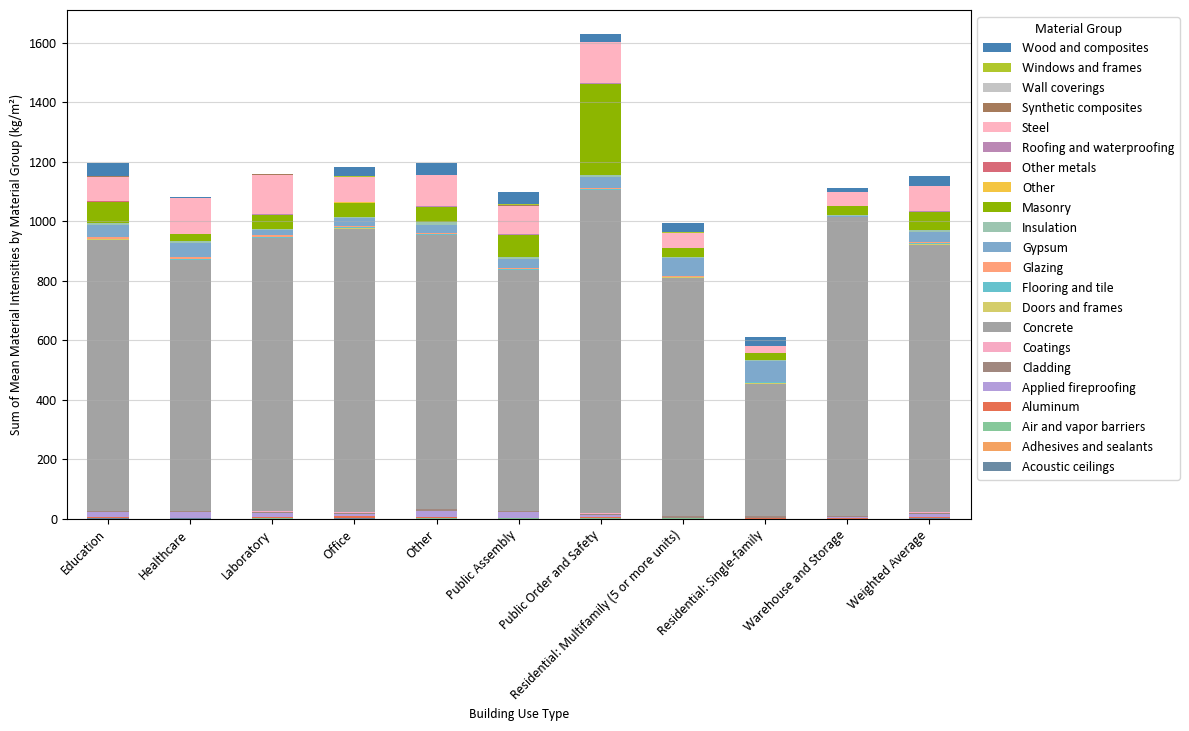

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# Assuming material_intensity_building_use_list is already loaded as in your original code

# Filter the dataframe for Material Intensity, 'mean', and 'No Filter'
material_filtered_df = material_intensity_building_use_list[
    (material_intensity_building_use_list['metric'].str.startswith('material_intensity')) &
    (material_intensity_building_use_list['measure'] == 'mean') &
    (material_intensity_building_use_list['filter'] == 'No Filter')
]

# Pivot the data to prepare for a stacked bar chart
material_pivot_df = material_filtered_df.pivot_table(
    index='building_use',
    columns='mat_group',
    values='value',
    aggfunc='sum'
)

# Define the colors
my_colors = [
    "#6b8ba4", "#f4a261", "#86c89a", "#e76f51", "#b39ddb", "#a1887f",
    "#f7aac3", "#a3a3a3", "#d4cd6a", "#66c2cd", "#ffa07a", "#7ea9cc",
    "#9cc5b0", "#8db600", "#f4c542", "#d86a78", "#bb88b4", "#ffb3c1",
    "#a67b5b", "#c4c4c4", "#b0c72c", "#4682b4"
]

# Ensure the number of colors matches the number of material categories
num_categories = len(material_pivot_df.columns)
if num_categories > len(my_colors):
    raise ValueError("Number of material categories exceeds the number of defined colors.")
elif num_categories < len(my_colors):
    my_colors = my_colors[:num_categories] #truncate the color list if there are fewer categories then colors.

# Plot the stacked bar chart with your custom colors
ax = material_pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    title='',
    xlabel='Building Use Type',
    ylabel='Sum of Mean Material Intensities by Material Group (kg/m²)',
    color=my_colors
)

# Reverse the order of handles and labels for the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Material Group', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='-', alpha=0.5)

# Show the plot
plt.show()

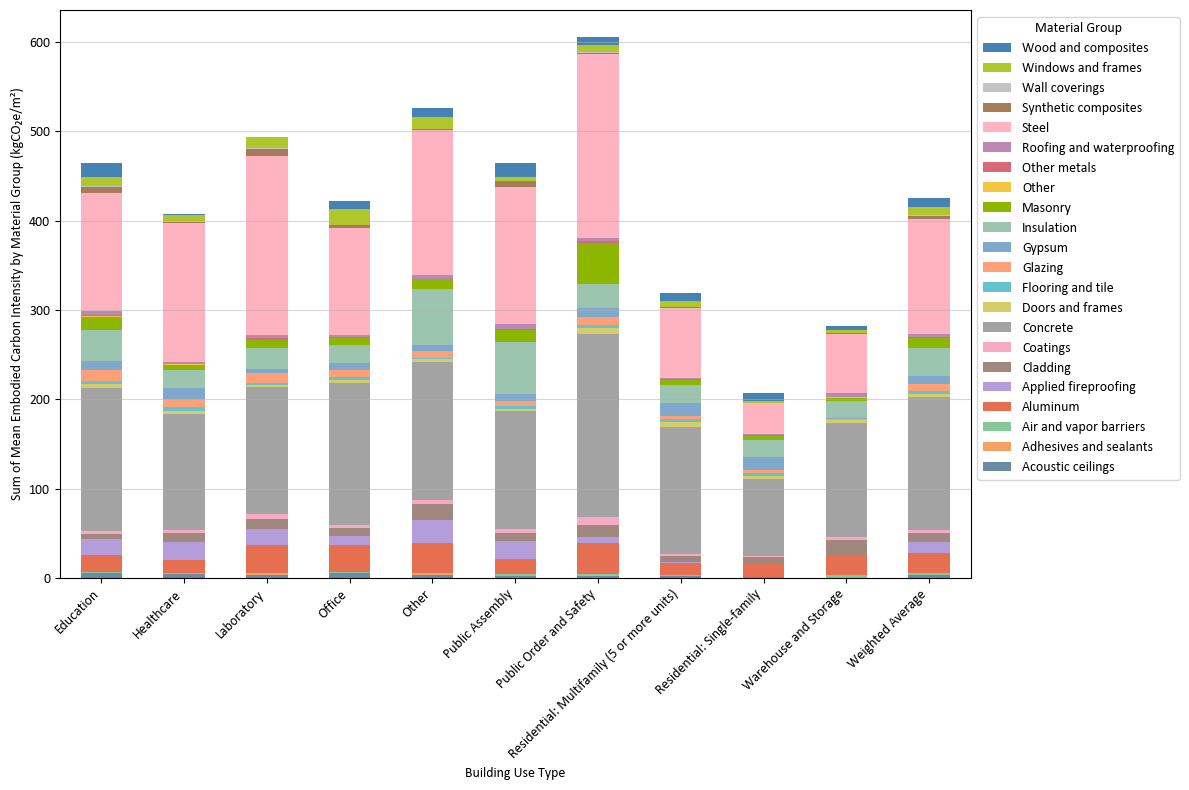

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming material_intensity_building_use_list is already loaded

# Filter the dataframe for GWP Intensity, 'mean', and 'No Filter'
gwp_filtered_df = material_intensity_building_use_list[
    (material_intensity_building_use_list['metric'].str.startswith('gwp_intensity')) &
    (material_intensity_building_use_list['measure'] == 'mean') &
    (material_intensity_building_use_list['filter'] == 'No Filter')
]

# Pivot the data to prepare for a stacked bar chart
gwp_pivot_df = gwp_filtered_df.pivot_table(
    index='building_use',
    columns='mat_group',
    values='value',
    aggfunc='sum'
)

# Define the colors
my_colors = [
    "#6b8ba4", "#f4a261", "#86c89a", "#e76f51", "#b39ddb", "#a1887f",
    "#f7aac3", "#a3a3a3", "#d4cd6a", "#66c2cd", "#ffa07a", "#7ea9cc",
    "#9cc5b0", "#8db600", "#f4c542", "#d86a78", "#bb88b4", "#ffb3c1",
    "#a67b5b", "#c4c4c4", "#b0c72c", "#4682b4"
]

# Ensure the number of colors matches the number of material categories
num_categories = len(gwp_pivot_df.columns)
if num_categories > len(my_colors):
    raise ValueError("Number of material categories exceeds the number of defined colors.")
elif num_categories < len(my_colors):
    my_colors = my_colors[:num_categories] #truncate the color list if there are fewer categories then colors.

# Plot the stacked bar chart with your custom colors
ax = gwp_pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    title='',
    xlabel='Building Use Type',
    ylabel='Sum of Mean Embodied Carbon Intensity by Material Group (kgCO₂e/m²)',
    color=my_colors
)

# Reverse the order of handles and labels for the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Material Group', bbox_to_anchor=(1, 1), loc='upper left')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees
plt.tight_layout()
plt.grid(axis='y', linestyle='-', alpha=0.5)

# Show the plot
plt.show()

## Floor area

In [96]:

# Specify the sheet name while reading the Excel file
rmi_projections = pd.read_excel('./Input Data/RMI Projections_CLF-format_2025-02-25.xlsx')

# Display the first few rows
rmi_projections.head()

# Sum up all growths for all building typologies.

# Create the new column with the specified summing conditions
rmi_projections['RMI_total_growth_million_m2'] = rmi_projections.drop(columns='year').sum(axis=1, skipna=True)

# Standardize column names in the dataframe by replacing `\n` with spaces
rmi_projections.columns = rmi_projections.columns.str.replace(r'\n', ' ', regex=True)

# Display the first few rows to verify the result
rmi_projections.head(10)


year  RMI_single_family_growth_million_m2  \
0  2020                           201.089366   
1  2021                           156.793574   
2  2022                           152.915339   
3  2023                           207.897483   
4  2024                           213.619292   
5  2025                           219.511135   
6  2026                           219.410366   
7  2027                           220.903245   
8  2028                           223.264748   
9  2029                           222.931368   

   RMI_multifamily_growth_million_m2  \
0                          32.652535   
1                          32.412584   
2                          32.220624   
3                          41.349520   
4                          37.110377   
5                          36.752592   
6                          37.099654   
7                          37.566172   
8                          37.831902   
9                          37.426215   

   RMI_warehouse and storage_growth_million_m2  RMI_office_growth_million_m2  \
0                                    31.051505                     26.864853   
1                                    34.795282                     25.532433   
2                                    34.813701                     29.387790   
3                                    30.803162                     36.508553   
4                                    32.320592                     37.973680   
5                                    35.273785                     41.085013   
6                                    34.315256                     39.624194   
7                                    33.991847                     38.913825   
8                                    35.868412                     40.711466   
9                                    37.883201                     42.633047   

   RMI_mercantile_service_growth_million_m2  \
0                                 31.058407   
1                                 16.474083   
2                                 28.163054   
3                                 33.420230   
4                                 34.783051   
5                                 37.656315   
6                                 36.339926   
7                                 35.710549   
8                                 37.383321   
9                                 39.171970   

   RMI_public assembly_growth_million_m2  RMI_education_growth_million_m2  \
0                              11.075910                        24.374824   
1                              11.634850                        35.220522   
2                              11.915179                        29.354910   
3                              20.206193                        26.415892   
4                              20.979671                        27.544394   
5                              22.658141                        29.875502   
6                              21.813375                        28.885332   
7                              21.383792                        28.438705   
8                              22.331295                        29.827297   
9                              23.343055                        31.313875   

   RMI_food service_growth_million_m2  RMI_lodging_growth_million_m2  \
0                            3.326991                      13.002289   
1                            1.522122                       8.495173   
2                            2.999189                      14.852519   
3                            3.671778                      13.090750   
4                            3.816896                      13.694424   
5                            4.127224                      14.901402   
6                            3.978160                      14.453892   
7                            3.904573                      14.276003   
8                            4.082582                      15.020764   
9                            4.272814                      15.8193

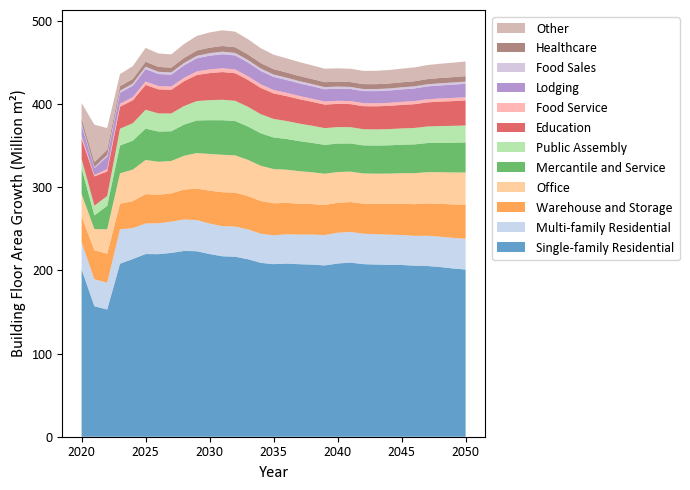

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

# Standardize dictionary keys (to ensure exact matching)
columns_to_plot = {
    'RMI_single_family_growth_million_m2': 'Single-family Residential',
    'RMI_multifamily_growth_million_m2': 'Multi-family Residential',
    'RMI_warehouse and storage_growth_million_m2': 'Warehouse and Storage',
    'RMI_office_growth_million_m2': 'Office',
    'RMI_mercantile_service_growth_million_m2': 'Mercantile and Service',
    'RMI_public assembly_growth_million_m2': 'Public Assembly',
    'RMI_education_growth_million_m2': 'Education',
    'RMI_food service_growth_million_m2': 'Food Service',
    'RMI_lodging_growth_million_m2': 'Lodging',
    'RMI_food sales_growth_million_m2': 'Food Sales',
    'RMI_healthcare_growth_million_m2': 'Healthcare',
    'RMI_other_growth_million_m2': 'Other'
}

# Filter the dataframe for years 2025 to 2050 and rename columns
years = list(range(2020, 2051))
filtered_df = rmi_projections[rmi_projections['year'].isin(years)][['year'] + list(columns_to_plot.keys())]
filtered_df = filtered_df.rename(columns=columns_to_plot).set_index('year')

# Define colors for each category
colors = plt.get_cmap('tab20').colors[:len(columns_to_plot)]

# Create the plot
plt.figure(figsize=(7, 5))
plt.stackplot(filtered_df.index, filtered_df.T, labels=columns_to_plot.values(), colors=colors, alpha=0.7)

# Customize the plot
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Building Floor Area Growth (Million m²)', fontsize=12)

# Reverse legend order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Set x-axis ticks to every 5 years from 2025 to 2050
plt.xticks(range(2020, 2051, 5), rotation=0)

plt.grid(False)
plt.tight_layout()
plt.show()


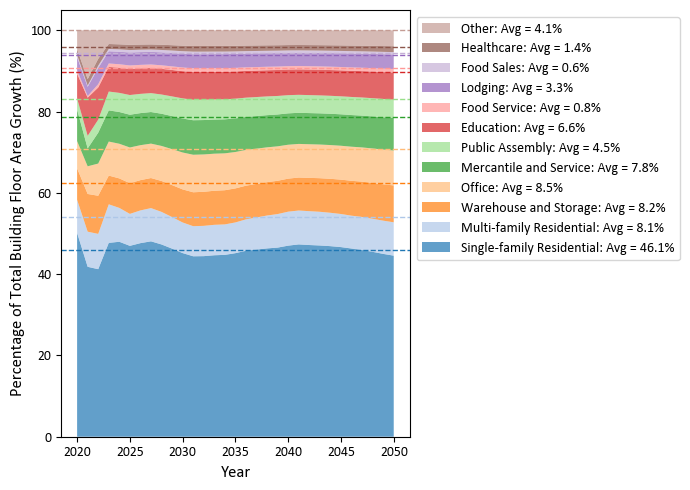

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter the dataframe for years 2020 to 2050 and select specific columns
years = list(range(2020, 2051))
columns_to_plot = {
    'RMI_single_family_growth_million_m2': 'Single-family Residential',
    'RMI_multifamily_growth_million_m2': 'Multi-family Residential',
    'RMI_warehouse and storage_growth_million_m2': 'Warehouse and Storage',
    'RMI_office_growth_million_m2': 'Office',
    'RMI_mercantile_service_growth_million_m2': 'Mercantile and Service',
    'RMI_public assembly_growth_million_m2': 'Public Assembly',
    'RMI_education_growth_million_m2': 'Education',
    'RMI_food service_growth_million_m2': 'Food Service',
    'RMI_lodging_growth_million_m2': 'Lodging',
    'RMI_food sales_growth_million_m2': 'Food Sales',
    'RMI_healthcare_growth_million_m2': 'Healthcare',
    'RMI_other_growth_million_m2': 'Other'
}

# Filter the dataframe and rename columns
filtered_df = rmi_projections[rmi_projections['year'].isin(years)][['year'] + list(columns_to_plot.keys())]
filtered_df = filtered_df.rename(columns=columns_to_plot).set_index('year')

# Normalize data to get percentages for each year (100% stacked)
filtered_df_percent = filtered_df.div(filtered_df.sum(axis=1), axis=0) * 100

# Define colors for each category
colors = plt.get_cmap('tab20').colors[:len(columns_to_plot)]

# Create the plot
plt.figure(figsize=(7, 5))
plt.stackplot(filtered_df_percent.index, filtered_df_percent.T, labels=columns_to_plot.values(), colors=colors, alpha=0.7)

# Calculate the average percentages
average_percentages = filtered_df_percent.mean()

# Add horizontal lines (cumulative average, but not used in legend)
cumulative_averages = filtered_df_percent.cumsum(axis=1).mean()
for i, col in enumerate(filtered_df_percent.columns):
    plt.axhline(y=cumulative_averages[col], color=colors[i], linestyle='--', linewidth=1)

# Customize the plot
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage of Total Building Floor Area Growth (%)', fontsize=12)

# Legend with average annotations
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [f'{label}: Avg = {average_percentages[col]:.1f}%' for col, label in zip(filtered_df_percent.columns, labels)]
plt.legend(handles[::-1], new_labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Set x-axis ticks to every 5 years from 2020 to 2050
plt.xticks(range(2020, 2051, 5), rotation=0)

# Remove gridlines and adjust layout
plt.grid(False)
plt.tight_layout()

# Show plot
plt.show()

In [115]:
import pandas as pd
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Assuming rmi_projections is your original dataframe
floor_area = rmi_projections

# Transpose the dataframe, setting 'year' as the index
transposed_floor_area = floor_area.set_index('year').T

# Strip unnecessary whitespaces and clean column names
transposed_floor_area.index = transposed_floor_area.index.str.strip().str.replace(r"\\n", " ", regex=True)

# List the rows to sum (cleaned names)
rows_to_sum = [
    'RMI_mercantile_service_growth_million_m2',
    'RMI_food service_growth_million_m2',
    'RMI_lodging_growth_million_m2',
    'RMI_food sales_growth_million_m2',
    'RMI_other_growth_million_m2'
]

# Ensure the rows exist in the index before summing
existing_rows = [row for row in rows_to_sum if row in transposed_floor_area.index]

# Calculate the sum across specified rows for each year
transposed_floor_area.loc['RMI_other_CLF_category_growth_million_m2'] = transposed_floor_area.loc[existing_rows].sum()

# Inspect the result
transposed_floor_area.tail(20)


year                                               2020        2021  \
RMI_single_family_growth_million_m2          201.089366  156.793574   
RMI_multifamily_growth_million_m2             32.652535   32.412584   
RMI_warehouse and storage_growth_million_m2   31.051505   34.795282   
RMI_office_growth_million_m2                  26.864853   25.532433   
RMI_mercantile_service_growth_million_m2      31.058407   16.474083   
RMI_public assembly_growth_million_m2         11.075910   11.634850   
RMI_education_growth_million_m2               24.374824   35.220522   
RMI_food service_growth_million_m2             3.326991    1.522122   
RMI_lodging_growth_million_m2                 13.002289    8.495173   
RMI_food sales_growth_million_m2               2.159967    1.206951   
RMI_healthcare_growth_million_m2               5.665639    5.885592   
RMI_other_growth_million_m2                   18.644615   45.037126   
RMI_total_growth_million_m2                  400.966902  375.010291   
RMI_other_CLF_category_growth_million_m2      68.192269   72.735454   

year                                               2022        2023  \
RMI_single_family_growth_million_m2          152.915339  207.897483   
RMI_multifamily_growth_million_m2             32.220624   41.349520   
RMI_warehouse and storage_growth_million_m2   34.813701   30.803162   
RMI_office_growth_million_m2                  29.387790   36.508553   
RMI_mercantile_service_growth_million_m2      28.163054   33.420230   
RMI_public assembly_growth_million_m2         11.915179   20.206193   
RMI_education_growth_million_m2               29.354910   26.415892   
RMI_food service_growth_million_m2             2.999189    3.671778   
RMI_lodging_growth_million_m2                 14.852519   13.090750   
RMI_food sales_growth_million_m2               2.037316    2.510803   
RMI_healthcare_growth_million_m2               6.283990    5.291853   
RMI_other_growth_million_m2                   25.997595   14.676111   
RMI_total_growth_million_m2                  370.941207  435.842328   
RMI_other_CLF_category_growth_million_m2      74.049674   67.369672   

year                                               2024        2025  \
RMI_single_family_growth_million_m2          213.619292  219.511135   
RMI_multifamily_growth_million_m2             37.110377   36.752592   
RMI_warehouse and storage_growth_million_m2   32.320592   35.273785   
RMI_office_growth_million_m2                  37.973680   41.085013   
RMI_mercantile_service_growth_million_m2      34.783051   37.656315   
RMI_public assembly_growth_million_m2         20.979671   22.658141   
RMI_education_growth_million_m2               27.544394   29.875502   
RMI_food service_growth_million_m2             3.816896    4.127224   
RMI_lodging_growth_million_m2                 13.694424   14.901402   
RMI_food sales_growth_million_m2               2.610062    2.822301   
RMI_healthcare_growth_million_m2               5.535224    6.022380   
RMI_other_growth_million_m2                   15.335090   16.667519   
RMI_total_growth_million_m2                  445.322754  467.353310   
RMI_other_CLF_category_growth_million_m2      70.239524   76.174761   

year                                               2026        2027  \
RMI_single_family_growth_million_m2          219.410366  220.903245   
RMI_multifamily_growth_million_m2             37.099654   37.566172   
RMI_warehouse and storage_growth_million_m2   34.315256   33.991847   
RMI_office_growth_million_m2                  39.624194   38.913825   
RMI_mercantile_service_growth_million_m2      36.339926   35.710549   
RMI_public assembly_growth_million_m2         21.813375   21.383792   
RMI_education_growth_million_m2               28.885332   28.438705   
RMI_food service_growth_million_m2             3.978160    3.904573   
RMI_lodging_growth_million_m2                 14.453892   14.276003   
RMI_food sales_growth_million_m2               2.720394    2.670101   
RMI_healthcare_growth

In [116]:
# Define the mapping dictionary based on the provided instructions
building_use_mapping = {
    "RMI_multifamily_growth_million_m2": "Residential: Multifamily (5 or more units)",
    "RMI_single_family_growth_million_m2": "Residential: Single-family",
    "RMI_office_growth_million_m2": "Office",
    "RMI_public assembly_growth_million_m2": "Public Assembly",
    "RMI_education_growth_million_m2": "Education",
    "RMI_healthcare_growth_million_m2": "Healthcare",
    "RMI_warehouse and storage_growth_million_m2": "Warehouse and Storage",
    "RMI_other_CLF_category_growth_million_m2": "Weighted Average"
    
}

# Add the building_use column using the mapping
transposed_floor_area["building_use"] = transposed_floor_area.index.map(building_use_mapping)

# Reorder columns to make building_use the second column
columns = ["building_use"] + [col for col in transposed_floor_area.columns if col != "building_use"]
transposed_floor_area = transposed_floor_area[columns]

transposed_floor_area.tail(18)

year                                                                       building_use  \
RMI_single_family_growth_million_m2                          Residential: Single-family   
RMI_multifamily_growth_million_m2            Residential: Multifamily (5 or more units)   
RMI_warehouse and storage_growth_million_m2                       Warehouse and Storage   
RMI_office_growth_million_m2                                                     Office   
RMI_mercantile_service_growth_million_m2                                            NaN   
RMI_public assembly_growth_million_m2                                   Public Assembly   
RMI_education_growth_million_m2                                               Education   
RMI_food service_growth_million_m2                                                  NaN   
RMI_lodging_growth_million_m2                                                       NaN   
RMI_food sales_growth_million_m2                                                    NaN   
RMI_healthcare_growth_million_m2                                             Healthcare   
RMI_other_growth_million_m2                                                         NaN   
RMI_total_growth_million_m2                                                         NaN   
RMI_other_CLF_category_growth_million_m2                               Weighted Average   

year                                               2020        2021  \
RMI_single_family_growth_million_m2          201.089366  156.793574   
RMI_multifamily_growth_million_m2             32.652535   32.412584   
RMI_warehouse and storage_growth_million_m2   31.051505   34.795282   
RMI_office_growth_million_m2                  26.864853   25.532433   
RMI_mercantile_service_growth_million_m2      31.058407   16.474083   
RMI_public assembly_growth_million_m2         11.075910   11.634850   
RMI_education_growth_million_m2               24.374824   35.220522   
RMI_food service_growth_million_m2             3.326991    1.522122   
RMI_lodging_growth_million_m2                 13.002289    8.495173   
RMI_food sales_growth_million_m2               2.159967    1.206951   
RMI_healthcare_growth_million_m2               5.665639    5.885592   
RMI_other_growth_million_m2                   18.644615   45.037126   
RMI_total_growth_million_m2                  400.966902  375.010291   
RMI_other_CLF_category_growth_million_m2      68.192269   72.735454   

year                                               2022        2023  \
RMI_single_family_growth_million_m2          152.915339  207.897483   
RMI_multifamily_growth_million_m2             32.220624   41.349520   
RMI_warehouse and storage_growth_million_m2   34.813701   30.803162   
RMI_office_growth_million_m2                  29.387790   36.508553   
RMI_mercantile_service_growth_million_m2      28.163054   33.420230   
RMI_public assembly_growth_million_m2         11.915179   20.206193   
RMI_education_growth_million_m2               29.354910   26.415892   
RMI_food service_growth_million_m2             2.999189    3.671778   
RMI_lodging_growth_million_m2                 14.852519   13.090750   
RMI_food sales_growth_million_m2               2.037316    2.510803   
RMI_healthcare_growth_million_m2               6.283990    5.291853   
RMI_other_growth_million_m2                   25.997595   14.676111   
RMI_total_growth_million_m2                  370.941207  435.842328   
RMI_other_CLF_category_growth_million_m2      74.049674   67.369672   

year                                               2024        2025  \
RMI_single_family_growth_million_m2          213.619292  219.511135   
RMI_multifamily_growth_million_m2             37.110377   36.752592   
RMI_warehouse and storage_growth_million_m2   32.320592   35.273785   
RMI_office_growth_million_m2                  37.973680   41.085013   
RMI_mercantile_service_growth_million_m2      34.783051   37.656315   
RMI_public assembly_growth_million_m2         20.979671   22.658141   
RMI_e

In [117]:
# Extract the column names from transposed_floor_area, excluding "building_use"
new_columns = [col for col in transposed_floor_area.columns if col != "building_use"]

# Add the new columns to the material_intensity_building_use_list dataframe with NaN values initially
for col in new_columns:
    material_intensity_building_use_list[col] = pd.NA

# Display the updated material_intensity_building_use_list dataframe to check the result
material_intensity_building_use_list.head()


mat_type               mat_group  \
0  Acoustic ceiling tile aluminum       Acoustic ceilings   
1     Acoustic ceiling tile fiber       Acoustic ceilings   
2     Acoustic ceiling tile steel       Acoustic ceilings   
3       Acoustic ceilings - other       Acoustic ceilings   
4          Adhesives and sealants  Adhesives and sealants   

                                  metric     filter      building_use measure  \
0  gwp_intensity_kg_per_m2_excluding_bio  No Filter  Weighted Average    mean   
1  gwp_intensity_kg_per_m2_excluding_bio  No Filter  Weighted Average    mean   
2  gwp_intensity_kg_per_m2_excluding_bio  No Filter  Weighted Average    mean   
3  gwp_intensity_kg_per_m2_excluding_bio  No Filter  Weighted Average    mean   
4  gwp_intensity_kg_per_m2_excluding_bio  No Filter  Weighted Average    mean   

      value  2020  2021  2022  ...  2041  2042  2043  2044  2045  2046  2047  \
0  0.939156  <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
1  0.885480  <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
2  0.612354  <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
3  0.732969  <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
4  0.393866  <NA>  <NA>  <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   

   2048  2049  2050  
0  <NA>  <NA>  <NA>  
1  <NA>  <NA>  <NA>  
2  <NA>  <NA>  <NA>  
3  <NA>  <NA>  <NA>  
4  <NA>  <NA>  <NA>  

[5 rows x 38 columns]

In [119]:
# Filter the material_intensity_building_use_list to include only rows where 'filter' is 'No Filter'
material_intensity_building_use_list = material_intensity_building_use_list[
    material_intensity_building_use_list['filter'] == 'No Filter'
]

# Convert year columns to strings if they are in numeric format
transposed_floor_area.columns = transposed_floor_area.columns.astype(str)

# Extract list of years from 2020 to 2050 for calculation columns
years = [str(year) for year in range(2020, 2051)]

# Prepare lists to store calculation results
material_intensity_results = []
gwp_intensity_results = []

# Iterate over each material category in material_intensity_building_use_list
for material_category, group in material_intensity_building_use_list.groupby("mat_type"):
    for _, row in group.iterrows():
        building_use = row['building_use']
        mat_group = row['mat_group']  # Extract the mat_group value
        
        # Ensure we're only using rows where measure is 'mean'
        if row['measure'] != 'mean':
            continue
        
        # Find matching row in transposed_floor_area
        floor_area_row = transposed_floor_area[transposed_floor_area['building_use'] == building_use]
        
        if not floor_area_row.empty:
            # Extract floor area values for the years (convert to numeric, ignore errors for NaNs)
            floor_area_values = floor_area_row[years].astype(float).values.flatten()
            
            # Calculate 'material_intensity_kg_per_m2' by multiplying mean with floor area values
            if row['metric'] == 'material_intensity_kg_per_m2':
                material_intensity_kg_per_m2 = (row['value'] * floor_area_values * 1000).tolist()
                material_intensity_results.append([material_category, mat_group, building_use] + material_intensity_kg_per_m2)
            
            # Calculate 'gwp_intensity_kg_per_m2_excluding_bio' by multiplying mean with floor area values
            elif row['metric'] == 'gwp_intensity_kg_per_m2_excluding_bio':
                gwp_intensity_kg_per_m2_excluding_bio = (row['value'] * floor_area_values * 1000).tolist()
                gwp_intensity_results.append([material_category, mat_group, building_use] + gwp_intensity_kg_per_m2_excluding_bio)

# Convert results to DataFrames and include 'mat_group' in the columns
material_intensity_df = pd.DataFrame(
    material_intensity_results, 
    columns=['mat_type', 'mat_group', 'building_use'] + years
)

gwp_intensity_df = pd.DataFrame(
    gwp_intensity_results, 
    columns=['mat_type', 'mat_group', 'building_use'] + years
)

# Display the resulting dataframes for verification
material_intensity_df.head()
gwp_intensity_df.head()


mat_type          mat_group      building_use  \
0  Acoustic ceiling tile aluminum  Acoustic ceilings  Weighted Average   
1  Acoustic ceiling tile aluminum  Acoustic ceilings         Education   
2  Acoustic ceiling tile aluminum  Acoustic ceilings        Healthcare   
3  Acoustic ceiling tile aluminum  Acoustic ceilings            Office   
4  Acoustic ceiling tile aluminum  Acoustic ceilings   Public Assembly   

           2020          2021          2022          2023          2024  \
0  64043.205442  68309.967152  69544.224543  63270.658017  65965.897680   
1  62797.329477  90739.309395  75627.620020  68055.770517  70963.152588   
2   3510.555172   3646.842662   3893.699350   3278.949326   3429.747241   
3  37977.198357  36093.637405  41543.720338  51609.907865  53681.067103   
4  17392.554926  18270.260607  18710.463502  31729.882120  32944.477820   

           2025          2026  ...          2041          2042          2043  \
0  71540.013725  69160.345454  ...  66174.675691  66019.271696  66232.424600   
1  76968.832539  74417.838483  ...  71367.848320  71213.004563  71455.947742   
2   3731.600072   3619.124828  ...   3630.385123   3633.049722   3656.008991   
3  58079.369429  56014.298594  ...  51696.644550  51449.297010  51489.148996   
4  35580.188069  34253.647590  ...  30749.662838  30544.136109  30509.215909   

           2044          2045          2046          2047          2048  \
0  66713.980240  67395.382992  68218.187878  69105.949738  70010.535746   
1  71988.821552  72737.812191  73639.960503  74612.787657  75604.416281   
2   3693.903533   3743.062361   3800.331549   3861.509841   3923.931710   
3  51736.416584  52136.562539  52643.330740  53197.084881  53760.492342   
4  30596.751160  30773.822915  31012.677012  31277.859822  31547.303809   

           2049          2050  
0  70892.857140  71710.827327  
1  76572.611092  77471.897434  
2   3985.411647   4043.563343  
3  54303.508579  54794.127628  
4  31803.373370  32027.417550  

[5 rows x 34 columns]

In [120]:
import plotly.express as px

# Define a function to create area charts for material categories
def create_material_area_chart(df, metric, y_axis_title, chart_title):
    # Ensure year columns are string formatted and filter to years 2020-2050
    df.columns = df.columns.astype(str)
    df = df[['mat_type'] + [str(year) for year in range(2020, 2051)]]

    # Group by material category
    df_grouped = df.groupby('mat_type').sum().reset_index()

    # Transpose the dataframe
    df_transposed = df_grouped.set_index('mat_type').transpose()
    df_transposed.index.name = 'year'
    df_transposed_reset = df_transposed.reset_index()

    # Melt the dataframe for area chart plotting
    df_melted = df_transposed_reset.melt(id_vars=['year'], var_name='mat_type', value_name='value')

    # Create the stacked area chart
    fig = px.area(
        df_melted,
        x='year',
        y='value',
        color='mat_type',
        title=chart_title,
        labels={'value': y_axis_title, 'year': 'Year', 'mat_type': 'Material Category'},
        color_discrete_sequence=px.colors.qualitative.Plotly  # Automatically assign colors
    )

    # Customize layout for styling consistency
    fig.update_layout(
        legend_title_text='Material Category',
        xaxis_title='Year',
        yaxis_title=y_axis_title,
        template='plotly_white',
        width=1200,
        height=1400,
        xaxis=dict(
            tickmode='array',
            tickvals=[str(year) for year in range(2020, 2051, 5)],  # Show every 5 years
            ticktext=[str(year) for year in range(2020, 2051, 5)],
            tickangle=0,  # Horizontal x-axis labels
            showticklabels=True,
            ticks="outside",  # Show tick marks outside the axis line
            ticklen=5,  # Length of the tick marks
            tickwidth=1,  # Thickness of tick marks
            tickcolor='black',  # Color of the tick marks
            showgrid=False,
            title_standoff=10
        ),
        yaxis=dict(
            title_standoff=10,
            ticks="outside",
            ticklen=5,  # Length of the tick marks
            tickwidth=1,  # Thickness of tick marks
            tickcolor='black',  # Color of the tick marks
            ticklabelposition='outside',
            ticklabelstandoff=10,
            showgrid=True
        ),
        showlegend=True,
        legend=dict(
            traceorder='reversed',
            yanchor="top",
            y=0.98,
            xanchor="left",
            x=1.02  # Moves legend outside the chart for better readability
        ),
        margin=dict(l=50, r=50, t=50, b=50)  # Adjust margins for cleaner layout
    )

    # Set area trace line widths to be thinner
    for trace in fig.data:
        trace.line.width = 0.1

    # Show the plot
    fig.show()

# 1. Total Mass Projection per Material Category
create_material_area_chart(
    material_intensity_df,
    metric='material_intensity_kg_per_m2',
    y_axis_title='Building Material Stock Projection (tons)',
    chart_title='Bottom-Up Approach: Total Mass Projection per Material Category By Building Type'
)

# 2. Total CO₂e Projection per Material Category
create_material_area_chart(
    gwp_intensity_df,
    metric='gwp_intensity_kg_per_m2_excluding_bio',
    y_axis_title='Total CO₂e Projection (Ton CO₂e)',
    chart_title='Bottom-Up Approach: Total CO₂e Projection per Material Category By Building Type'
)


In [121]:
import plotly.express as px

# Define a function to create 100% stacked area charts for material categories
def create_100pct_material_area_chart(df, metric, y_axis_title, chart_title):
    # Ensure year columns are string formatted and filter to years 2020-2050
    df.columns = df.columns.astype(str)
    df = df[['mat_type'] + [str(year) for year in range(2020, 2051)]]

    # Group by material category and sum
    df_grouped = df.groupby('mat_type').sum().reset_index()

    # Transpose the dataframe
    df_transposed = df_grouped.set_index('mat_type').transpose()
    df_transposed.index.name = 'year'
    df_transposed_reset = df_transposed.reset_index()

    # Normalize values to make each year sum to 100%
    df_transposed_reset.iloc[:, 1:] = df_transposed_reset.iloc[:, 1:].div(df_transposed_reset.iloc[:, 1:].sum(axis=1), axis=0) * 100

    # Melt the dataframe for area chart plotting
    df_melted = df_transposed_reset.melt(id_vars=['year'], var_name='mat_type', value_name='value')

    # Create the 100% stacked area chart with dynamic colors
    fig = px.area(
        df_melted, 
        x='year', 
        y='value', 
        color='mat_type',
        title=chart_title,
        labels={'value': y_axis_title, 'year': 'Year', 'mat_type': 'Material Category'},
        color_discrete_sequence=px.colors.qualitative.Plotly  # Automatically assign colors
    )

    # Customize layout for styling consistency
    fig.update_layout(
        legend_title_text='Material Category',
        xaxis_title='Year',
        yaxis_title=y_axis_title,
        template='plotly_white',
        width=850,
        height=650,
        xaxis=dict(
            tickmode='array',
            tickvals=[str(year) for year in range(2020, 2051, 5)],  # Show every 5 years
            ticktext=[str(year) for year in range(2020, 2051, 5)],
            tickangle=0,
            showticklabels=True,
            ticks="outside",
            ticklen=5,
            tickwidth=1,
            tickcolor='black',
            showgrid=False,
            title_standoff=10
        ),
        yaxis=dict(
            title_standoff=10,
            ticks="outside",
            ticklen=5,
            tickwidth=1,
            tickcolor='black',
            ticklabelposition='outside',
            ticklabelstandoff=10,
            showgrid=True
        ),
        showlegend=True,
        legend=dict(
            traceorder='reversed',
            yanchor="top",
            y=0.98,
            xanchor="left",
            x=1.02
        ),
        margin=dict(l=50, r=50, t=50, b=50)
    )

    # Show the plot
    fig.show()

# Example usage for a 100% stacked area chart
create_100pct_material_area_chart(
    gwp_intensity_df, 
    metric='gwp_intensity_kg_per_m2_excluding_bio', 
    y_axis_title='Percentage of Total CO₂e Projection (%)', 
    chart_title='Bottom-Up Approach: CO₂e Contribution per Material Type and Individual Building Type'
)


In [122]:
import plotly.express as px

# Define a function to create area charts for building use categories
def create_building_use_area_chart(df, metric, y_axis_title, chart_title):
    # Ensure year columns are string formatted and filter to years 2020-2050
    df.columns = df.columns.astype(str)
    df = df[['building_use'] + [str(year) for year in range(2020, 2051)]]

    # Group by building use
    df_grouped = df.groupby('building_use').sum().reset_index()

    # Transpose the dataframe
    df_transposed = df_grouped.set_index('building_use').transpose()
    df_transposed.index.name = 'year'
    df_transposed_reset = df_transposed.reset_index()

    # Melt the dataframe for area chart plotting
    df_melted = df_transposed_reset.melt(id_vars=['year'], var_name='building_use', value_name='value')

    # Create the stacked area chart with dynamic color assignment
    fig = px.area(
        df_melted, 
        x='year', 
        y='value', 
        color='building_use',
        title=chart_title,
        labels={'value': y_axis_title, 'year': 'Year', 'building_use': 'Building Use'},
        color_discrete_sequence=px.colors.qualitative.Plotly  # Automatically assign colors
    )

    # Update layout to match styling specifications
    fig.update_layout(
        legend_title_text='Building Use',
        xaxis_title='Year',
        yaxis_title=y_axis_title,
        template='plotly_white',
        width=850,
        height=650,
        xaxis=dict(
            tickmode='array',
            tickvals=[str(year) for year in range(2020, 2051, 5)],  # Show every 5 years
            ticktext=[str(year) for year in range(2020, 2051, 5)],
            tickangle=0,
            showticklabels=True,
            ticks="outside",
            ticklen=5,
            tickwidth=1,
            tickcolor='black',
            showgrid=False,
            title_standoff=10
        ),
        yaxis=dict(
            title_standoff=10,
            ticks="outside",
            ticklen=5,
            tickwidth=1,
            tickcolor='black',
            ticklabelposition='outside',
            ticklabelstandoff=10,
            showgrid=True
        ),
        showlegend=True,
        legend=dict(
            traceorder='reversed',
            yanchor="top",
            y=0.98,
            xanchor="left",
            x=1.02
        ),
        margin=dict(l=50, r=50, t=50, b=50)
    )

    # Set area trace line widths to be thinner
    for trace in fig.data:
        trace.line.width = 1

    # Display the plot
    fig.show()

# Example usage:
create_building_use_area_chart(
    material_intensity_df, 
    metric='material_intensity_kg_per_m2', 
    y_axis_title='Building Material Stock Projection (tons)', 
    chart_title='Bottom-Up Approach: Total Mass Projection per Building Use by Building Type'
)

create_building_use_area_chart(
    gwp_intensity_df, 
    metric='gwp_intensity_kg_per_m2_excluding_bio', 
    y_axis_title='Total CO₂e Projection (Ton CO₂e)', 
    chart_title='Bottom-Up Approach: Total CO₂e Projection per Building Use by Building Type'
)


In [123]:
import plotly.express as px

# Function to create a 100% stacked area chart for CO₂e projection per building use
def create_100pct_co2e_projection_chart(df, yaxis_title, chart_title):
    # Ensure year columns are string formatted and filter to years 2020-2050
    df.columns = df.columns.astype(str)
    df = df[['building_use'] + [str(year) for year in range(2020, 2051)]]

    # Group by building use
    df_grouped = df.groupby('building_use').sum().reset_index()

    # Transpose the dataframe
    df_transposed = df_grouped.set_index('building_use').transpose()
    df_transposed.index.name = 'year'
    df_transposed_reset = df_transposed.reset_index()

    # Melt the dataframe for area chart plotting
    df_melted = df_transposed_reset.melt(id_vars=['year'], var_name='building_use', value_name='value')

    # Normalize each year to make it 100%
    df_melted['value'] = df_melted.groupby('year')['value'].transform(lambda x: x / x.sum() * 100)

    # Create the 100% stacked area chart with dynamic color assignment
    fig = px.area(
        df_melted, 
        x='year', 
        y='value', 
        color='building_use',
        title=chart_title,
        labels={'value': yaxis_title, 'year': 'Year', 'building_use': 'Building Use'},
        color_discrete_sequence=px.colors.qualitative.Plotly  # Automatically assign colors
    )

    # Customize layout for clear styling
    fig.update_layout(
        legend_title_text='Building Use',
        xaxis_title='Year',
        yaxis_title=yaxis_title,
        template='plotly_white',
        width=850,
        height=650,
        xaxis=dict(
            tickmode='array',
            tickvals=[str(year) for year in range(2020, 2051, 5)],
            tickangle=0,
            showticklabels=True,
            ticks="outside",
            ticklen=5,
            tickwidth=1,
            tickcolor='black',
            showgrid=False,
            title_standoff=10
        ),
        yaxis=dict(
            title_standoff=10,
            ticks="outside",
            ticklen=5,
            tickwidth=1,
            tickcolor='black',
            ticklabelposition='outside',
            ticklabelstandoff=10,
            showgrid=True
        ),
        showlegend=True,
        legend=dict(
            traceorder='reversed',
            yanchor="top",
            y=0.98,
            xanchor="left",
            x=1.02
        ),
        margin=dict(l=50, r=50, t=50, b=50)
    )

    # Show the plot
    fig.show()

# Example usage:
create_100pct_co2e_projection_chart(
    gwp_intensity_df, 
    yaxis_title='Percentage of Total CO₂e Projection (%)', 
    chart_title='100% Stacked CO₂e Projection per Building Use (2020-2050)'
)


## Projection data extraction

### Mass and carbon stocks

In [126]:
import pandas as pd

# Function to prepare and export data for material or carbon stock projection
def prepare_and_export_table_format(df, output_file):
    # Ensure year columns are string formatted and filter to years 2020-2050
    df.columns = df.columns.astype(str)
    df = df[['mat_type'] + [str(year) for year in range(2020, 2051)]]

    # Group by material category and sum
    df_grouped = df.groupby('mat_type').sum().reset_index()

    # Export the data to a CSV file
    df_grouped.to_csv(output_file, index=False)
    print(f"Exported table format data to {output_file}")

# Prepare and export material stock projection data in table format
prepare_and_export_table_format(
    material_intensity_df,
    output_file='./Output Data/material_stock_projection_by_wedge_categories.csv'
)

# Prepare and export carbon stock projection data in table format
prepare_and_export_table_format(
    gwp_intensity_df,
    output_file='./Output Data/carbon_stock_projection_by_wedge_categories.csv'
)


Exported table format data to ./Output Data/material_stock_projection_by_wedge_categories.csv
Exported table format data to ./Output Data/carbon_stock_projection_by_wedge_categories.csv


### GWP factor

In [127]:
import pandas as pd

# Function to calculate GWP factor for year 2020
def calculate_and_export_gwp_factor(material_stock_file, carbon_stock_file, output_file):
    # Load material and carbon stock data
    material_df = pd.read_csv(material_stock_file)
    carbon_df = pd.read_csv(carbon_stock_file)
    
    # Extract data for year 2020
    material_2020 = material_df[['mat_type', '2020']]
    carbon_2020 = carbon_df[['mat_type', '2020']]
    
    # Rename the columns for clarity
    material_2020.rename(columns={'2020': 'material_stock_2020'}, inplace=True)
    carbon_2020.rename(columns={'2020': 'carbon_stock_2020'}, inplace=True)
    
    # Merge material and carbon data on material categories
    merged_df_projections = pd.merge(material_2020, carbon_2020, on='mat_type')
    
    # Calculate GWP factor (carbon stock / material stock for year 2025)
    merged_df_projections['gwp_factor'] = merged_df_projections['carbon_stock_2020'] / merged_df_projections['material_stock_2020']
    
    # Keep only relevant columns
    result_df = merged_df_projections[['mat_type', 'gwp_factor']]
    
    # Export the result as a CSV file
    result_df.to_csv(output_file11, index=False)
    print(f"GWP factor data exported to {output_file11}")

# File paths
material_stock_file = './Output Data/material_stock_projection_by_wedge_categories.csv'
carbon_stock_file = './Output Data/carbon_stock_projection_by_wedge_categories.csv'
output_file11 = './Output Data/gwp_factor_by_material_category_2020.csv'

# Calculate and export GWP factor
calculate_and_export_gwp_factor(material_stock_file, carbon_stock_file, output_file11)


GWP factor data exported to ./Output Data/gwp_factor_by_material_category_2020.csv
